In [2]:
import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
import rasterio

import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools
import matplotlib.colors as mcolors
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import warnings
import pandas
import pickle
import matplotlib as mpl

In [8]:
# Check pandas version
import pandas as pd
print(pd.__version__)


2.2.1


In [3]:
 #get the IPBES sub regions
# Read the shapefile

shp_dir = "/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/IPBES_Regions_Subregions2.shp"
shp = gpd.read_file(shp_dir)

# Define the region mapping
region_mapping = {
    'Carribean': 'Caribbean & Mesoamerica',
    'Central Africa': 'West, Central, East & South Africa',
    'Central and Western Europe': 'Central and Western Europe',
    'Central Asia': 'Central, North-East & South Asia',
    'East Africa and adjacent islands': 'West, Central, East & South Africa',
    'Eastern Europe': 'Eastern Europe',
    'Mesoamerica': 'Caribbean & Mesoamerica',
    'North Africa': 'North Africa & Western Asia',
    'North America': 'North America'
    ,
    'Nort-East Asia': 'Central, North-East & South Asia',
    'Oceania': 'Oceania',
    'South America': 'South America',
    'South Asia': 'Central, North-East & South Asia',
    'South-East Asia': 'South-East Asia',
    'Southern Africa': 'West, Central, East & South Africa',
    'West Africa': 'West, Central, East & South Africa',
    'Western Asia': 'North Africa & Western Asia'
}

# Create the new_region column in the shapefile
shp['new_region'] = shp['Sub_Region'].map(region_mapping)


In [7]:

output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/habitats/"

# Assuming you have already read the shapefile and created the 'new_region' column
# If not, include the relevant code for reading and creating the 'new_region' column from your previous messages

regionlist = ['Central, North-East & South Asia','West, Central, East & South Africa', 'Central and Western Europe','North Africa & Western Asia', 'South America','Eastern Europe', 'Oceania', 'Caribbean & Mesoamerica', 'South-East Asia', 'North America'             ]
# Create an empty dictionary to store mean species richness for each region and each scenario
mean_species_richness_dict = {'sumbin_future': {}, 'sumbin_hist': {}, 'diff_sumbin': {}}
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenario = ["rcp26", "rcp60"] 
habitats=["cropland","pasture","forest","natural_land"]
scenarios = ["rcp26", "rcp60"]
historical_time = 1146
future_time = 65
time = '65'
time_ind=65


mean_newvalue_hist= {}
mean_newvalue_fut = {}
mean_sumbin_hist = {}
mean_sumbin_fut = {}
    
mean_over_sdms_gcms_hist = {}
mean_over_sdms_gcms_fut = {}
mean_over_sdms_gcms_sumbin_hist = {}
mean_over_sdms_gcms_sumbin_fut = {}

mean_over_all_sdms_gcms_hist = {}
mean_over_all_sdms_gcms_fut = {}
mean_over_all_sdms_gcms_sumbin_hist = {}
mean_over_all_sdms_gcms_sumbin_fut = {}


for scenario in scenarios:

    mean_over_sdms_gcms_hist[scenario] = {}
    mean_over_sdms_gcms_fut[scenario] = {}
    mean_over_sdms_gcms_sumbin_hist[scenario] = {}
    mean_over_sdms_gcms_sumbin_fut[scenario] = {}
    
    mean_over_all_sdms_gcms_hist[scenario] = {}
    mean_over_all_sdms_gcms_fut[scenario] = {}
    mean_over_all_sdms_gcms_sumbin_hist[scenario] = {}
    mean_over_all_sdms_gcms_sumbin_fut[scenario] = {}
    
    mean_newvalue_hist[scenario] = {}
    mean_newvalue_fut[scenario] = {}
    mean_sumbin_hist[scenario] = {}
    mean_sumbin_fut[scenario] = {}
    
    dataarrays_sdms_newvalue_hist = []
    dataarrays_sdms_newvalue_fut = []
    dataarrays_sdms_sumbin_hist = []
    dataarrays_sdms_sumbin_fut = []

    for habitat in habitats:

        # Initialize taxa-level lists
        dataarrays_sdms_newvalue_hist = []
        dataarrays_sdms_newvalue_fut = []
        dataarrays_sdms_sumbin_hist = []
        dataarrays_sdms_sumbin_fut = []
        
        mean_over_sdms_gcms_hist[scenario][habitat] = {}
        mean_over_sdms_gcms_fut[scenario][habitat] = {}
        mean_over_sdms_gcms_sumbin_hist[scenario][habitat] = {}
        mean_over_sdms_gcms_sumbin_fut[scenario][habitat] = {}

        mean_over_all_sdms_gcms_hist[scenario][habitat] = {}
        mean_over_all_sdms_gcms_fut[scenario][habitat] = {}
        mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat] = {}
        mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat] = {}

        mean_newvalue_hist[scenario][habitat] = {}
        mean_newvalue_fut[scenario][habitat] = {}
        mean_sumbin_hist[scenario][habitat] = {}
        mean_sumbin_fut[scenario][habitat] = {}

        for sdm in sdms:

            mean_newvalue_hist[scenario][habitat][sdm] = {}
            mean_newvalue_fut[scenario][habitat][sdm] = {}
            mean_sumbin_hist[scenario][habitat][sdm] = {}
            mean_sumbin_fut[scenario][habitat][sdm] = {}

            dataarrays_newvalue_hist = []
            dataarrays_newvalue_fut = []
            dataarrays_sumbin_hist = []
            dataarrays_sumbin_fut = []


            for gcm in gcms:
                mean_newvalue_hist[scenario][habitat][sdm][gcm] = {}
                mean_newvalue_fut[scenario][habitat][sdm][gcm] = {}
                mean_sumbin_hist[scenario][habitat][sdm][gcm] = {}
                mean_sumbin_fut[scenario][habitat][sdm][gcm] = {}

                sum_newvalue_hist = None
                sum_newvalue_future = None
                sum_sumbin_hist = None
                sum_sumbin_future = None

                # Load pickle files
                newvalue_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}']_dispersal4_newbase.pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}']_dispersal4_newbase.pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}']_dispersal4.pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}']_dispersal4.pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_taxa = pd.read_pickle(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_taxa = pd.read_pickle(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_taxa = pd.read_pickle(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_taxa = pd.read_pickle(f)
                    
                weights_newvalue = np.cos(np.deg2rad(newvalue_hist_taxa.lat))
                weights_newvalue.name = "weights"

                    
                # Assign the summed values to your dictionary
                mean_newvalue_hist[scenario][habitat][sdm][gcm] = newvalue_hist_taxa
                mean_newvalue_fut[scenario][habitat][sdm][gcm] = newvalue_future_taxa
                mean_sumbin_hist[scenario][habitat][sdm][gcm] = sum_bin_hist_taxa
                mean_sumbin_fut[scenario][habitat][sdm][gcm] = sum_bin_future_taxa

                dataarrays_newvalue_hist.append(mean_newvalue_hist[scenario][habitat][sdm][gcm])
                dataarrays_newvalue_fut.append(mean_newvalue_fut[scenario][habitat][sdm][gcm])
                dataarrays_sumbin_hist.append(mean_sumbin_hist[scenario][habitat][sdm][gcm])
                dataarrays_sumbin_fut.append(mean_sumbin_fut[scenario][habitat][sdm][gcm])
                

            # Concatenate and calculate the mean over the new dimension
            mean_over_sdms_gcms_hist[scenario][habitat][sdm] = xr.concat(dataarrays_newvalue_hist, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')
            mean_over_sdms_gcms_fut[scenario][habitat][sdm] = xr.concat(dataarrays_newvalue_fut, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')
            mean_over_sdms_gcms_sumbin_hist[scenario][habitat][sdm] = xr.concat(dataarrays_sumbin_hist, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')
            mean_over_sdms_gcms_sumbin_fut[scenario][habitat][sdm] = xr.concat(dataarrays_sumbin_fut, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')

                   # Append the mean DataArrays across GCMs to the SDM lists
            dataarrays_sdms_newvalue_hist.append(mean_over_sdms_gcms_hist[scenario][habitat][sdm])
            dataarrays_sdms_newvalue_fut.append(mean_over_sdms_gcms_fut[scenario][habitat][sdm])
            dataarrays_sdms_sumbin_hist.append(mean_over_sdms_gcms_sumbin_hist[scenario][habitat][sdm])
            dataarrays_sdms_sumbin_fut.append(mean_over_sdms_gcms_sumbin_fut[scenario][habitat][sdm])

        # Concatenate and calculate the mean over SDMs
        mean_over_all_sdms_gcms_hist[scenario][habitat] = xr.concat(dataarrays_sdms_newvalue_hist, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
        mean_over_all_sdms_gcms_fut[scenario][habitat] = xr.concat(dataarrays_sdms_newvalue_fut, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
        mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat] = xr.concat(dataarrays_sdms_sumbin_hist, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
        mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat] = xr.concat(dataarrays_sdms_sumbin_fut, dim='sdm').weighted(weights_newvalue).mean(dim='sdm') 

In [ ]:
import matplotlib as mpl
def set_plot_param():

    """Set my own customized plotting parameters"""

    import matplotlib as mpl

    mpl.rc('axes',edgecolor='grey')

    mpl.rc('axes',labelcolor='black')

    mpl.rc('xtick',color='black')

    mpl.rc('xtick',labelsize=14)

    mpl.rc('ytick',color='black')

    mpl.rc('ytick',labelsize=14)

    mpl.rc('axes',titlesize=18)

    mpl.rc('axes',labelsize=14)

    mpl.rc('legend',fontsize='large')

    mpl.rc('text',color='black')
    

    

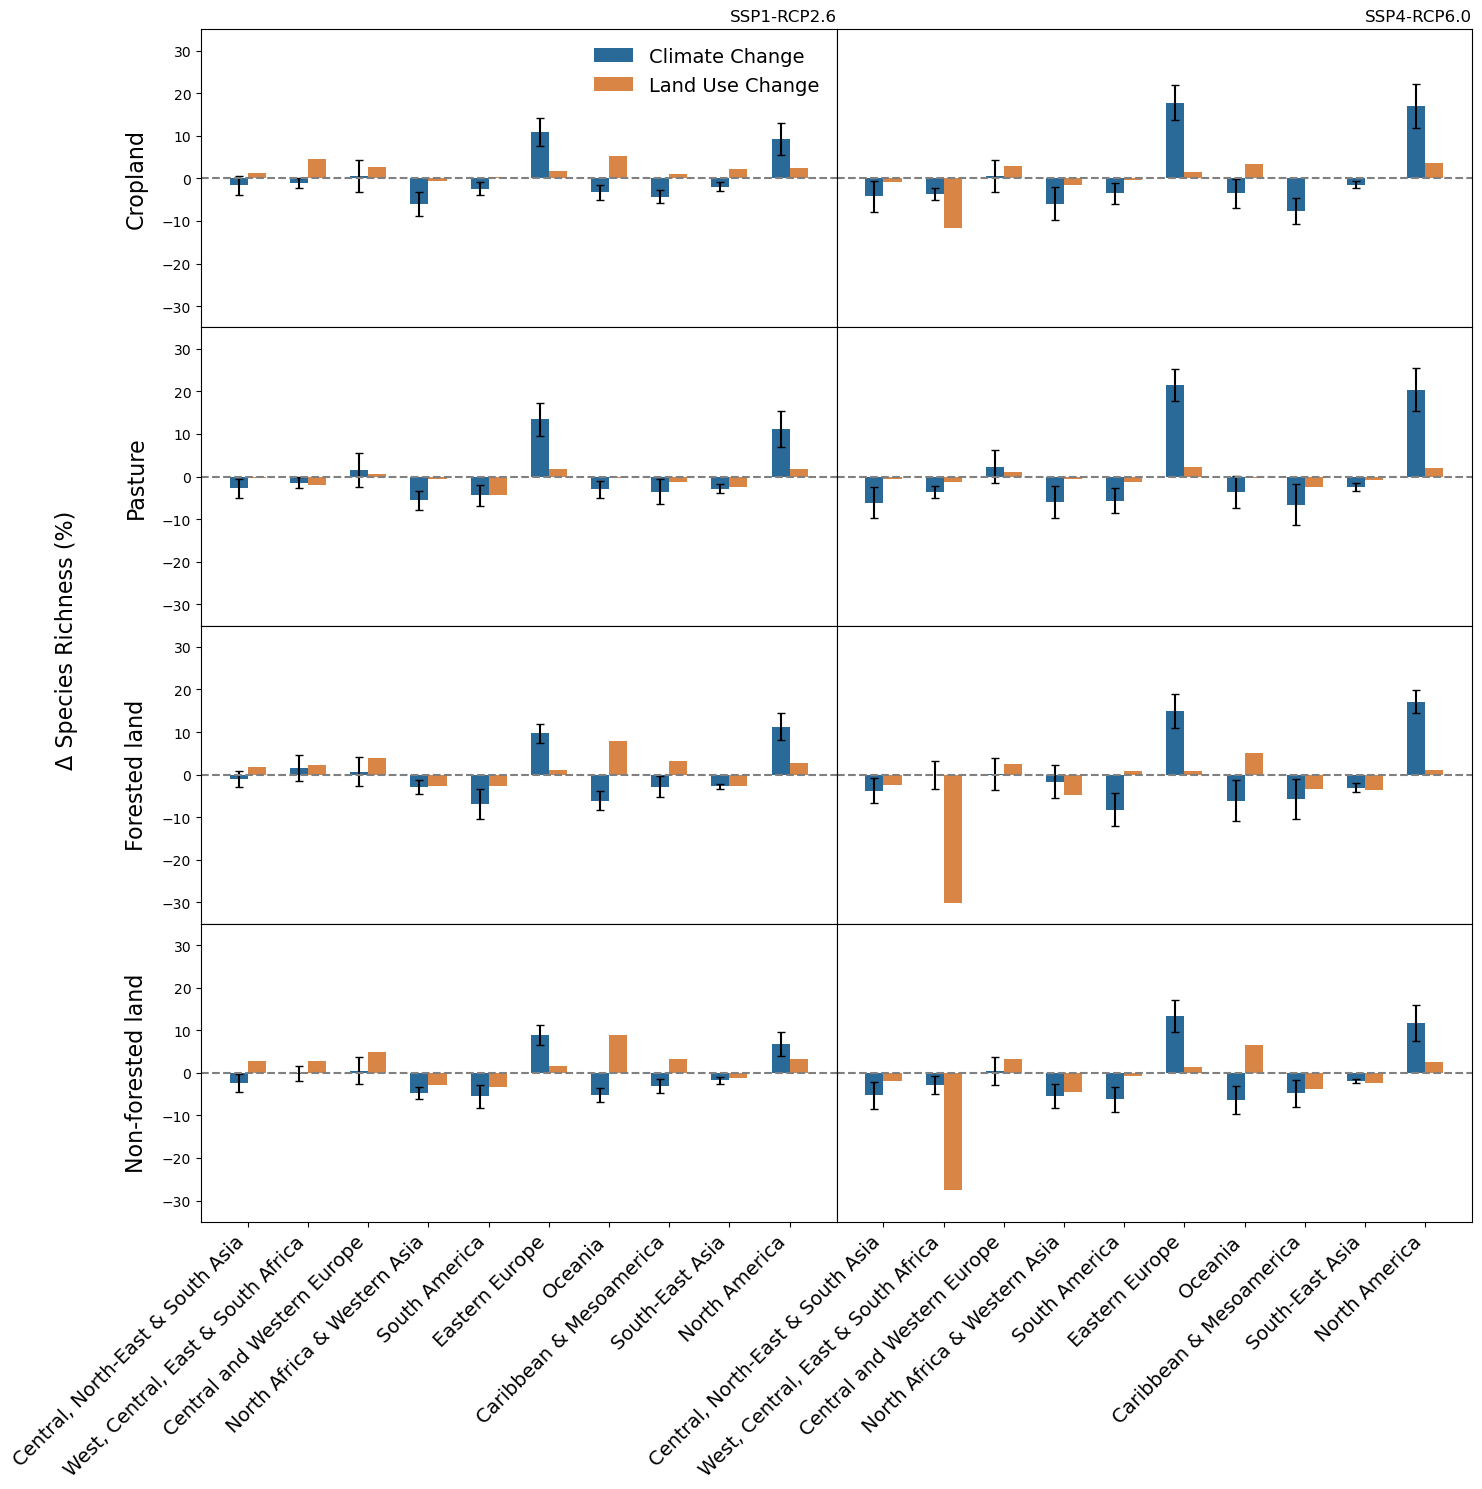

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib as mpl

# Define some parameters for the bar plots
width = 0.5 # the width of the bars
min_threshold = 1e-6
# Create the x-axis positions for the bars
x = np.arange(len(regionlist)) / 2
scenario_indices={"rcp26": 'SSP1-RCP2.6', "rcp60": 'SSP4-RCP6.0'}
habitat_indices={"forest": 'Forested land', "natural_land": 'Non-forested land',"cropland": 'Cropland',"pasture": 'Pasture'}


# Create the x-axis positions for the bars
x = np.arange(len(regionlist))  # Assuming regionlist is the list of all regions




# Define figure and axes for the matrix of plots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))  # Adjust the size as needed

# Loop over each habitat and scenario to create each subplot
for i, habitat in enumerate(habitats):
    for j, scenario in enumerate(scenarios):
        ax = axes[i][j]  # This is the current axes object to plot on

        # Initialize lists for plotting
        rel_diff_newvalue_means = []
        rel_diff_sumbins = []
        std_dev_newvalue = []

        # Iterate over each region for the specific habitat and scenario
        for region in regionlist:
            oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
            oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
            sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/LandClim_Output/Dispersal4/GAM/Amphibians/EWEMBI/Abavorana_luctuosa_[1146].nc", decode_times=False).to_array().isel(variable=0)
            oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

            # Calculate th
            newvalue_future = mean_over_all_sdms_gcms_fut[scenario][habitat]
            newvalue_hist = mean_over_all_sdms_gcms_hist[scenario][habitat]
            sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat]
            sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat]



            # Calculate the relative difference safely
            non_zero_mask = sumbin_future != 0
            newvalue_hist_filtered = newvalue_hist.where(newvalue_hist > min_threshold, np.nan)
            difference = xr.where(newvalue_hist != 0, (newvalue_future - newvalue_hist) / newvalue_hist_filtered * 100, 0)
            climate_change = difference.where((difference >= -100) & (difference <= 100))

            climate_change = climate_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            sumbin_hist_filtered = sumbin_hist.where(sumbin_hist > min_threshold, np.nan)
            difference = (sumbin_future - sumbin_hist_filtered) / sumbin_hist_filtered * 100
            climate_land_change = difference.where((difference >= -100) & (difference <= 100))

            climate_land_change = climate_land_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            luc = climate_land_change - climate_change

            rel_diff_newvalue_mean = climate_change.mean()
            rel_diff_sumbin = luc.mean()

            # Append the values to the list
            rel_diff_newvalue_means.append(rel_diff_newvalue_mean)
            rel_diff_sumbins.append(rel_diff_sumbin)


            means_for_std = []

            for sdm in sdms:
                for gcm in gcms:

                    sep_future = mean_newvalue_fut[scenario][habitat][sdm][gcm]
                    sep_hist = mean_newvalue_hist[scenario][habitat][sdm][gcm]
                    sep_hist_filtered = sep_hist.where(sep_hist > min_threshold, np.nan)
                    difference = xr.where(sep_hist != 0, (sep_future - sep_hist) / sep_hist_filtered * 100, 0)
                    relative_change = difference.where((difference >= -100) & (difference <= 100))
                    relative_change = relative_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)

                    # Calculate the mean for this SDM and GCM
                    mean_relative_change = np.nanmean(relative_change.values)
                    means_for_std.append(mean_relative_change)

            # Compute the standard deviation of these means
            std_dev_newvalue_region = np.nanstd(means_for_std)
            std_dev_newvalue.append(std_dev_newvalue_region)

        total_heights = np.array(rel_diff_newvalue_means) + np.array(rel_diff_sumbins)

        # Plotting the bars
        width = 0.3 # the width of the bars
        offset = width / 2  # Half the width of the bar
        x1 = x - offset  # Positions for the first set of bars
        x2 = x + offset  # Positions for the second set of bars

        # Plotting the bars with alpha for transparency
        ax.bar(x1, rel_diff_newvalue_means, width, label='Climate Change', color="#2a6a99")
        ax.bar(x2, rel_diff_sumbins, width, label='Land Use Change', color="#d88546")
        

        

        # Adding error bars
        ax.errorbar(x1,rel_diff_newvalue_means, yerr=std_dev_newvalue, fmt='none', capsize=3, color='black')

        ax.set_ylim([-35, 35])
        ax.axhline(y=0, color='gray', linestyle='--')
        # If this is the last row, set the x-tick labels
        if i == len(habitats) - 1:
            ax.set_xticks(x)
            ax.set_xticklabels(regionlist, rotation=45, ha='right', fontsize=14)
        else:
            ax.set_xticks([])  # No x-tick labels for other rows

        # If this is the first column, set the y-label

            
        if j == 1:
            ax.set_yticks([])


        # Set the title for the top row
        if i == 0:
            ax.set_title(f'{scenario_indices[scenario]}',loc='right')

        # Add the legend only for the first subplot or as per your preference
        if i == 0 and j == 0:
            ax.legend(frameon=False, fontsize=14)

# Add the habitat labels on the right side of the plot matrix
for i, habitat in enumerate(habitats):
    axes[i, -1].text(-1.12, 0.5, habitat_indices[habitat], transform=axes[i, -1].transAxes, rotation=90, va='center', fontsize=16)

fig.text(0.045, 0.57, 'Δ Species Richness (%)', va='center', rotation='vertical',fontsize=16)
set_plot_param()
# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)  # Adjust this value as needed
plt.savefig("/storage/homefs/ch21o450/scripts/climate_Hari_etal_inprep/functions/figures/main_figures/Figure_3.png")
# Show the plot
plt.show()

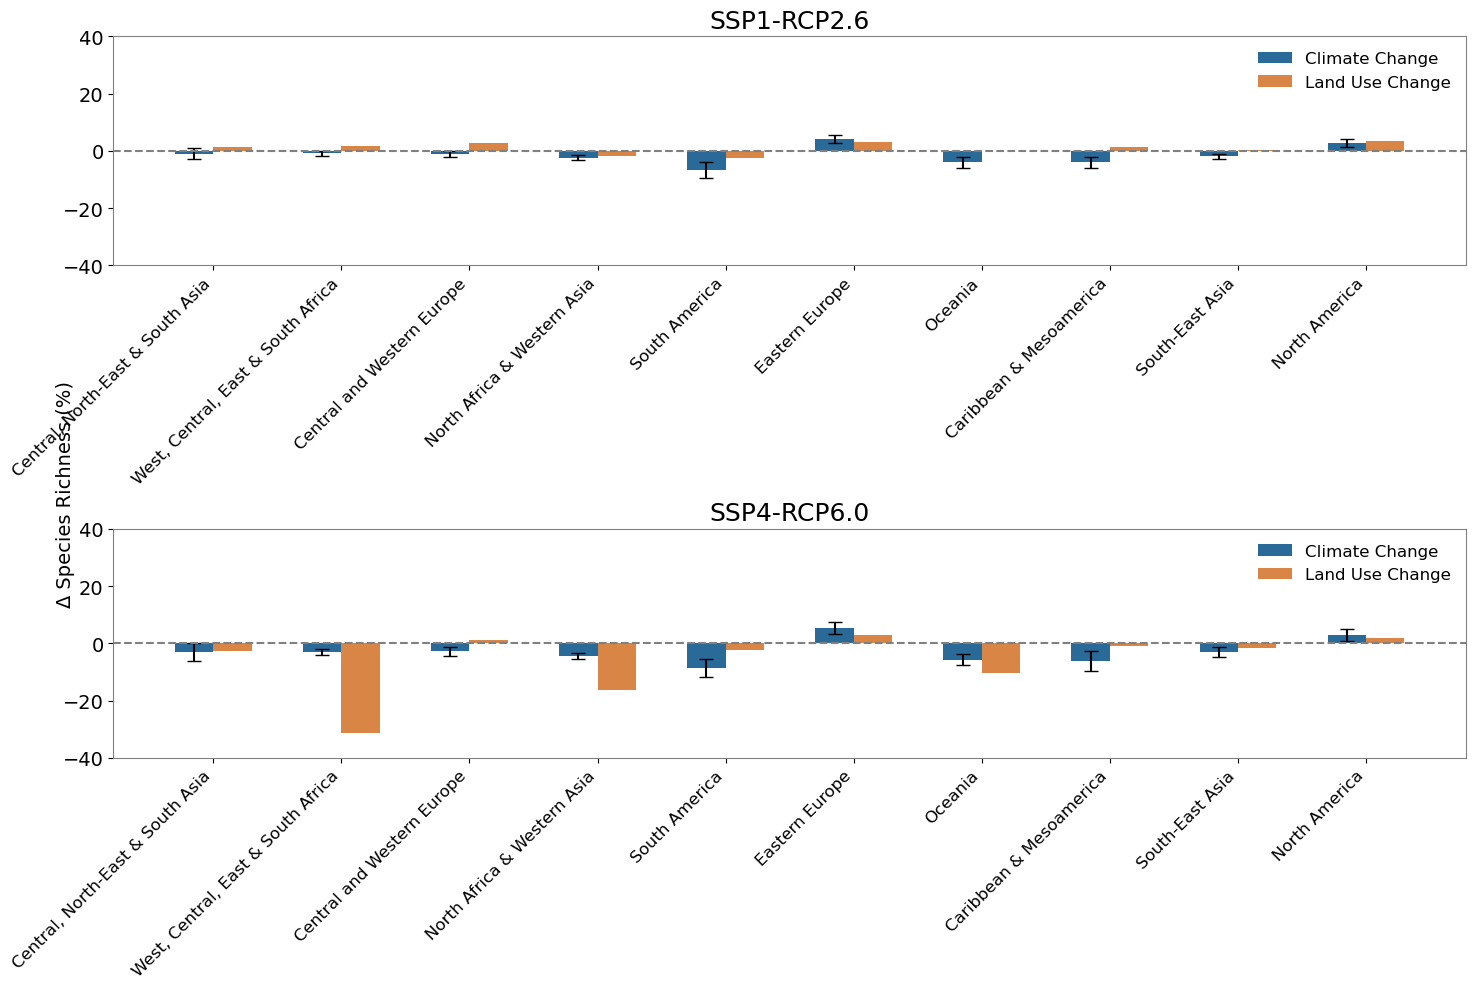

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Define the parameters for the bar plots
width = 0.3  # Width of the bars
scenarios = ["rcp26", "rcp60"]
scenario_indices = {"rcp26": 'SSP1-RCP2.6', "rcp60": 'SSP4-RCP6.0'}
regions = ["Central, North-East & South Asia", "West, Central, East & South Africa", 
           "Central and Western Europe", "North Africa & Western Asia", 
           "South America", "Eastern Europe", "Oceania", 
           "Caribbean & Mesoamerica", "South-East Asia", "North America"]

# Summary data from the provided table
climate_change_data = {
    "SSP1-RCP2.6": [-1.0, -0.8, -1.0, -2.4, -6.7, 4.1, -4.0, -4.0, -1.9, 2.6],
    "SSP4-RCP6.0": [-2.9, -3.1, -2.8, -4.5, -8.6, 5.3, -5.7, -6.1, -3.1, 2.9]
}
climate_land_change_data = {
    "SSP1-RCP2.6": [0.3, 1.0, 1.9, -4.1, -9.1, 7.3, -3.9, -2.7, -1.7, 6.2],
    "SSP4-RCP6.0": [-5.5, -34.5, -1.6, -20.7, -10.9, 8.1, -16.2, -6.9, -4.7, 4.7]
}
# Uncertainty values for "Climate Change"
climate_change_uncertainty = {
    "SSP1-RCP2.6": [1.9, 0.9, 1.1, 0.9, 2.8, 1.4, 1.9, 1.9, 0.9, 1.4],
    "SSP4-RCP6.0": [3.1, 1.1, 1.5, 1.1, 3.2, 2.0, 2.0, 3.5, 1.8, 2.0]
}

# Calculate Land Use Change as the difference between Climate and Land Use Change and Climate Change
land_use_change_data = {
    scenario: [
        climate_land_change_data[scenario][i] - climate_change_data[scenario][i]
        for i in range(len(regions))
    ]
    for scenario in scenario_indices.values()
}

# Define figure and axes for the matrix of plots (1 row for each scenario)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))  # 2 rows for the two scenarios

# Plot data for each scenario
for j, scenario in enumerate(scenario_indices.keys()):
    ax = axes[j]
    climate_means = climate_change_data[scenario_indices[scenario]]
    land_use_means = land_use_change_data[scenario_indices[scenario]]
    uncertainty = climate_change_uncertainty[scenario_indices[scenario]]

    # Create x positions
    x = np.arange(len(regions))

    # Plot Climate Change and Land Use Change values
    ax.bar(x - width / 2, climate_means, width, label='Climate Change', color="#2a6a99", yerr=uncertainty, capsize=5)
    ax.bar(x + width / 2, land_use_means, width, label='Land Use Change', color="#d88546")
    ax.axhline(0, color='gray', linestyle='--')
    
    # Set x-ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels(regions, rotation=45, ha='right', fontsize=12)
    ax.set_title(f"{scenario_indices[scenario]}")
    ax.set_ylim([-40, 40])  # Adjust y-axis limits as needed

    # Add legend
    ax.legend(frameon=False, fontsize=12)

# Add y-axis label for the entire figure
fig.text(0.05, 0.5, 'Δ Species Richness (%)', va='center', rotation='vertical', fontsize=14)

# Adjust layout and save figure
plt.tight_layout()
plt.savefig("/storage/homefs/ch21o450/scripts/climate_Hari_etal_inprep/functions/figures/main_figures/Figure_Climate_vs_Land_Use_with_Uncertainty.png")
plt.show()


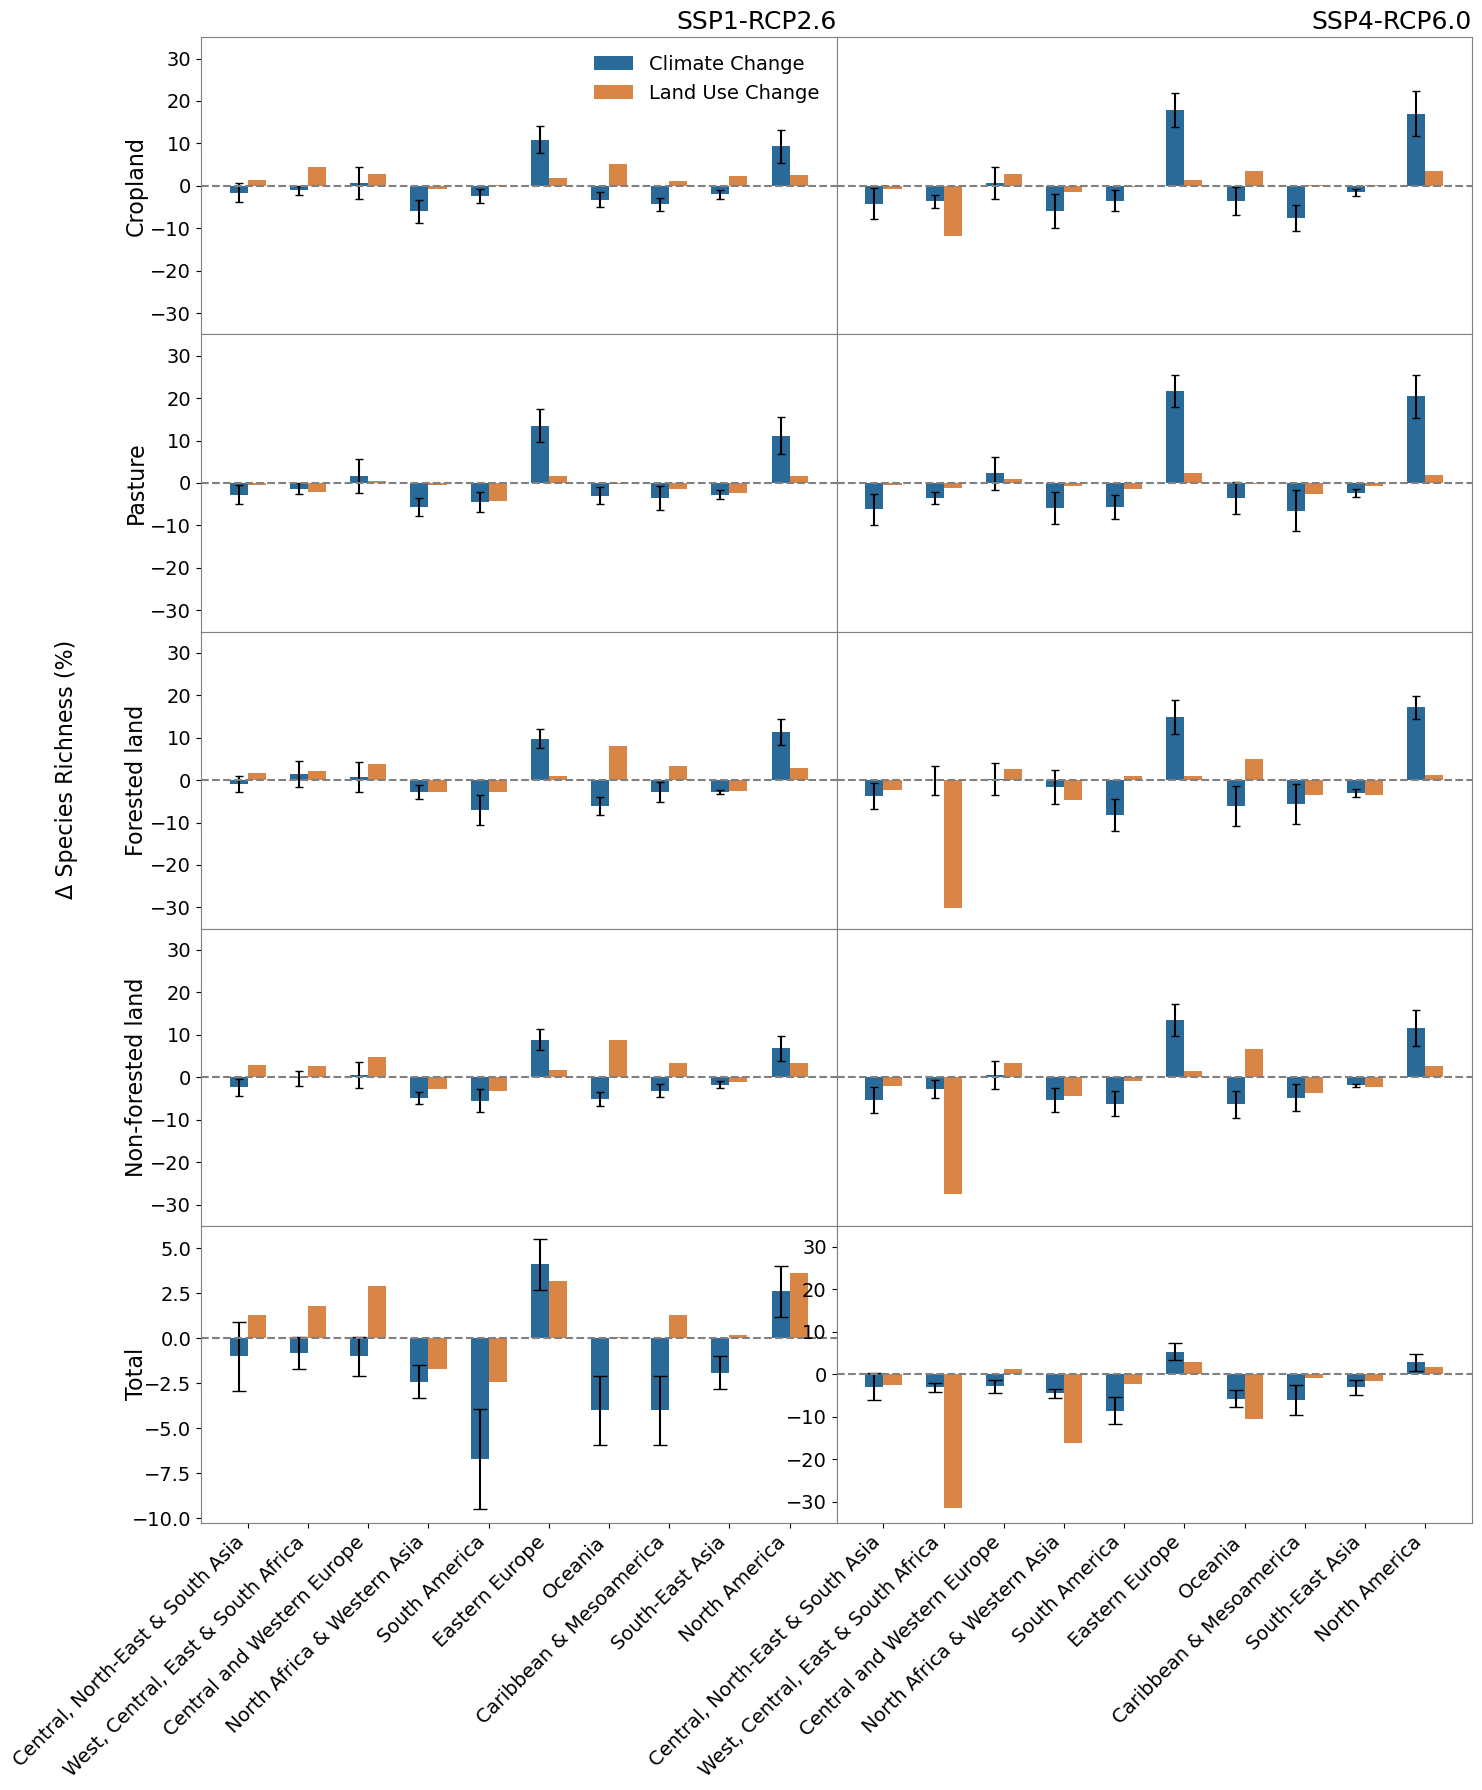

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib as mpl

# Define some parameters for the bar plots
width = 0.3  # Width of the bars
min_threshold = 1e-6
x = np.arange(len(regionlist))  # Assuming regionlist is the list of all regions
scenario_indices = {"rcp26": 'SSP1-RCP2.6', "rcp60": 'SSP4-RCP6.0'}
habitat_indices = {"forest": 'Forested land', "natural_land": 'Non-forested land', "cropland": 'Cropland', "pasture": 'Pasture'}

# Define figure and axes for the matrix of plots, now with 5 rows (4 habitats + 1 total)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))  # Adjust size to fit all rows

# Loop over each habitat and scenario to create the original 4 panels
for i, habitat in enumerate(habitats):
    for j, scenario in enumerate(scenarios):
        ax = axes[i][j]  # Current axes object for plotting

        # Initialize lists for plotting values and errors
        rel_diff_newvalue_means = []
        rel_diff_sumbins = []
        std_dev_newvalue = []

        # Iterate over each region for the specific habitat and scenario
        for region in regionlist:
            # Load required datasets and masks for actual calculations
            oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
            oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
            sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/LandClim_Output/Dispersal4/GAM/Amphibians/EWEMBI/Abavorana_luctuosa_[1146].nc", decode_times=False).to_array().isel(variable=0)
            oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

            # Calculate climate and land use change relative differences
            newvalue_future = mean_over_all_sdms_gcms_fut[scenario][habitat]
            newvalue_hist = mean_over_all_sdms_gcms_hist[scenario][habitat]
            sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat]
            sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat]

            non_zero_mask = sumbin_future != 0
            newvalue_hist_filtered = newvalue_hist.where(newvalue_hist > min_threshold, np.nan)
            difference_climate = xr.where(newvalue_hist != 0, (newvalue_future - newvalue_hist) / newvalue_hist_filtered * 100, 0)
            climate_change = difference_climate.where((difference_climate >= -100) & (difference_climate <= 100))
            climate_change = climate_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)

            sumbin_hist_filtered = sumbin_hist.where(sumbin_hist > min_threshold, np.nan)
            difference_land = (sumbin_future - sumbin_hist_filtered) / sumbin_hist_filtered * 100
            climate_land_change = difference_land.where((difference_land >= -100) & (difference_land <= 100))
            climate_land_change = climate_land_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)

            # Land Use Change (calculated as difference between climate and climate + land use change)
            luc = climate_land_change - climate_change
            rel_diff_newvalue_means.append(climate_change.mean().item())
            rel_diff_sumbins.append(luc.mean().item())

            # Calculate standard deviation
            means_for_std = []
            for sdm in sdms:
                for gcm in gcms:
                    sep_future = mean_newvalue_fut[scenario][habitat][sdm][gcm]
                    sep_hist = mean_newvalue_hist[scenario][habitat][sdm][gcm]
                    sep_hist_filtered = sep_hist.where(sep_hist > min_threshold, np.nan)
                    difference_sep = xr.where(sep_hist != 0, (sep_future - sep_hist) / sep_hist_filtered * 100, 0)
                    relative_change = difference_sep.where((difference_sep >= -100) & (difference_sep <= 100))
                    relative_change = relative_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)
                    means_for_std.append(np.nanmean(relative_change.values))
            std_dev_newvalue.append(np.nanstd(means_for_std))

        # Define x positions for bars
        x1 = x - width / 2  # Positions for "Climate Change" bars
        x2 = x + width / 2  # Positions for "Land Use Change" bars

        # Plot Climate Change and Land Use Change bars
        ax.bar(x1, rel_diff_newvalue_means, width, label='Climate Change', color="#2a6a99")
        ax.bar(x2, rel_diff_sumbins, width, label='Land Use Change', color="#d88546")

        # Add error bars only to Climate Change
        ax.errorbar(x1, rel_diff_newvalue_means, yerr=std_dev_newvalue, fmt='none', capsize=3, color='black')

        # Set limits and aesthetics
        ax.set_ylim([-35, 35])
        ax.axhline(y=0, color='gray', linestyle='--')



        # Set y-ticks only for the left column
        if j == 1:
            ax.set_yticks([])

        # Set titles for the first row
        if i == 0:
            ax.set_title(f'{scenario_indices[scenario]}', loc='right')

        # Add legend in the first subplot
        if i == 0 and j == 0:
            ax.legend(frameon=False, fontsize=14)

# Summary data from the provided table
climate_change_data = {
    "SSP1-RCP2.6": [-1.0, -0.8, -1.0, -2.4, -6.7, 4.1, -4.0, -4.0, -1.9, 2.6],
    "SSP4-RCP6.0": [-2.9, -3.1, -2.8, -4.5, -8.6, 5.3, -5.7, -6.1, -3.1, 2.9]
}
climate_land_change_data = {
    "SSP1-RCP2.6": [0.3, 1.0, 1.9, -4.1, -9.1, 7.3, -3.9, -2.7, -1.7, 6.2],
    "SSP4-RCP6.0": [-5.5, -34.5, -1.6, -20.7, -10.9, 8.1, -16.2, -6.9, -4.7, 4.7]
}
# Uncertainty values for "Climate Change"
climate_change_uncertainty = {
    "SSP1-RCP2.6": [1.9, 0.9, 1.1, 0.9, 2.8, 1.4, 1.9, 1.9, 0.9, 1.4],
    "SSP4-RCP6.0": [3.1, 1.1, 1.5, 1.1, 3.2, 2.0, 2.0, 3.5, 1.8, 2.0]
}

# Calculate Land Use Change as the difference between Climate and Land Use Change and Climate Change
land_use_change_data = {
    scenario: [
        climate_land_change_data[scenario][i] - climate_change_data[scenario][i]
        for i in range(len(regions))
    ]
    for scenario in scenario_indices.values()
}
# Plot total summary in the fifth row
for j, scenario in enumerate(scenarios):
    ax_totals = axes[4, j]
    climate_means = climate_change_data[scenario_indices[scenario]]
    land_means = land_use_change_data[scenario_indices[scenario]]
    uncertainty = climate_change_uncertainty[scenario_indices[scenario]]

    # Plot bars and add error bars to Climate Change only
    ax_totals.bar(x - width / 2, climate_means, width, label='Climate Change', color="#2a6a99", yerr=uncertainty, capsize=5)
    ax_totals.bar(x + width / 2, land_means, width, label='Land Use Change', color="#d88546")
    ax_totals.axhline(0, color='gray', linestyle='--')

    # Set x-ticks and labels for the regions
    ax_totals.set_xticks(x)
    ax_totals.set_xticklabels(regionlist, rotation=45, ha='right', fontsize=14)
    ax_totals.set_ylim([-35, 35])

# Add habitat labels on the right side of the plot matrix
for i, habitat in enumerate(habitats):
    axes[i, -1].text(-1.12, 0.5, habitat_indices[habitat], transform=axes[i, -1].transAxes, rotation=90, va='center', fontsize=16)
axes[4, -1].text(-1.12, 0.5, "Total", transform=axes[4, -1].transAxes, rotation=90, va='center', fontsize=16)

# Add y-axis label for the entire figure
fig.text(0.045, 0.57, 'Δ Species Richness (%)', va='center', rotation='vertical', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)  # Adjust as needed

# Display the plot
plt.show()


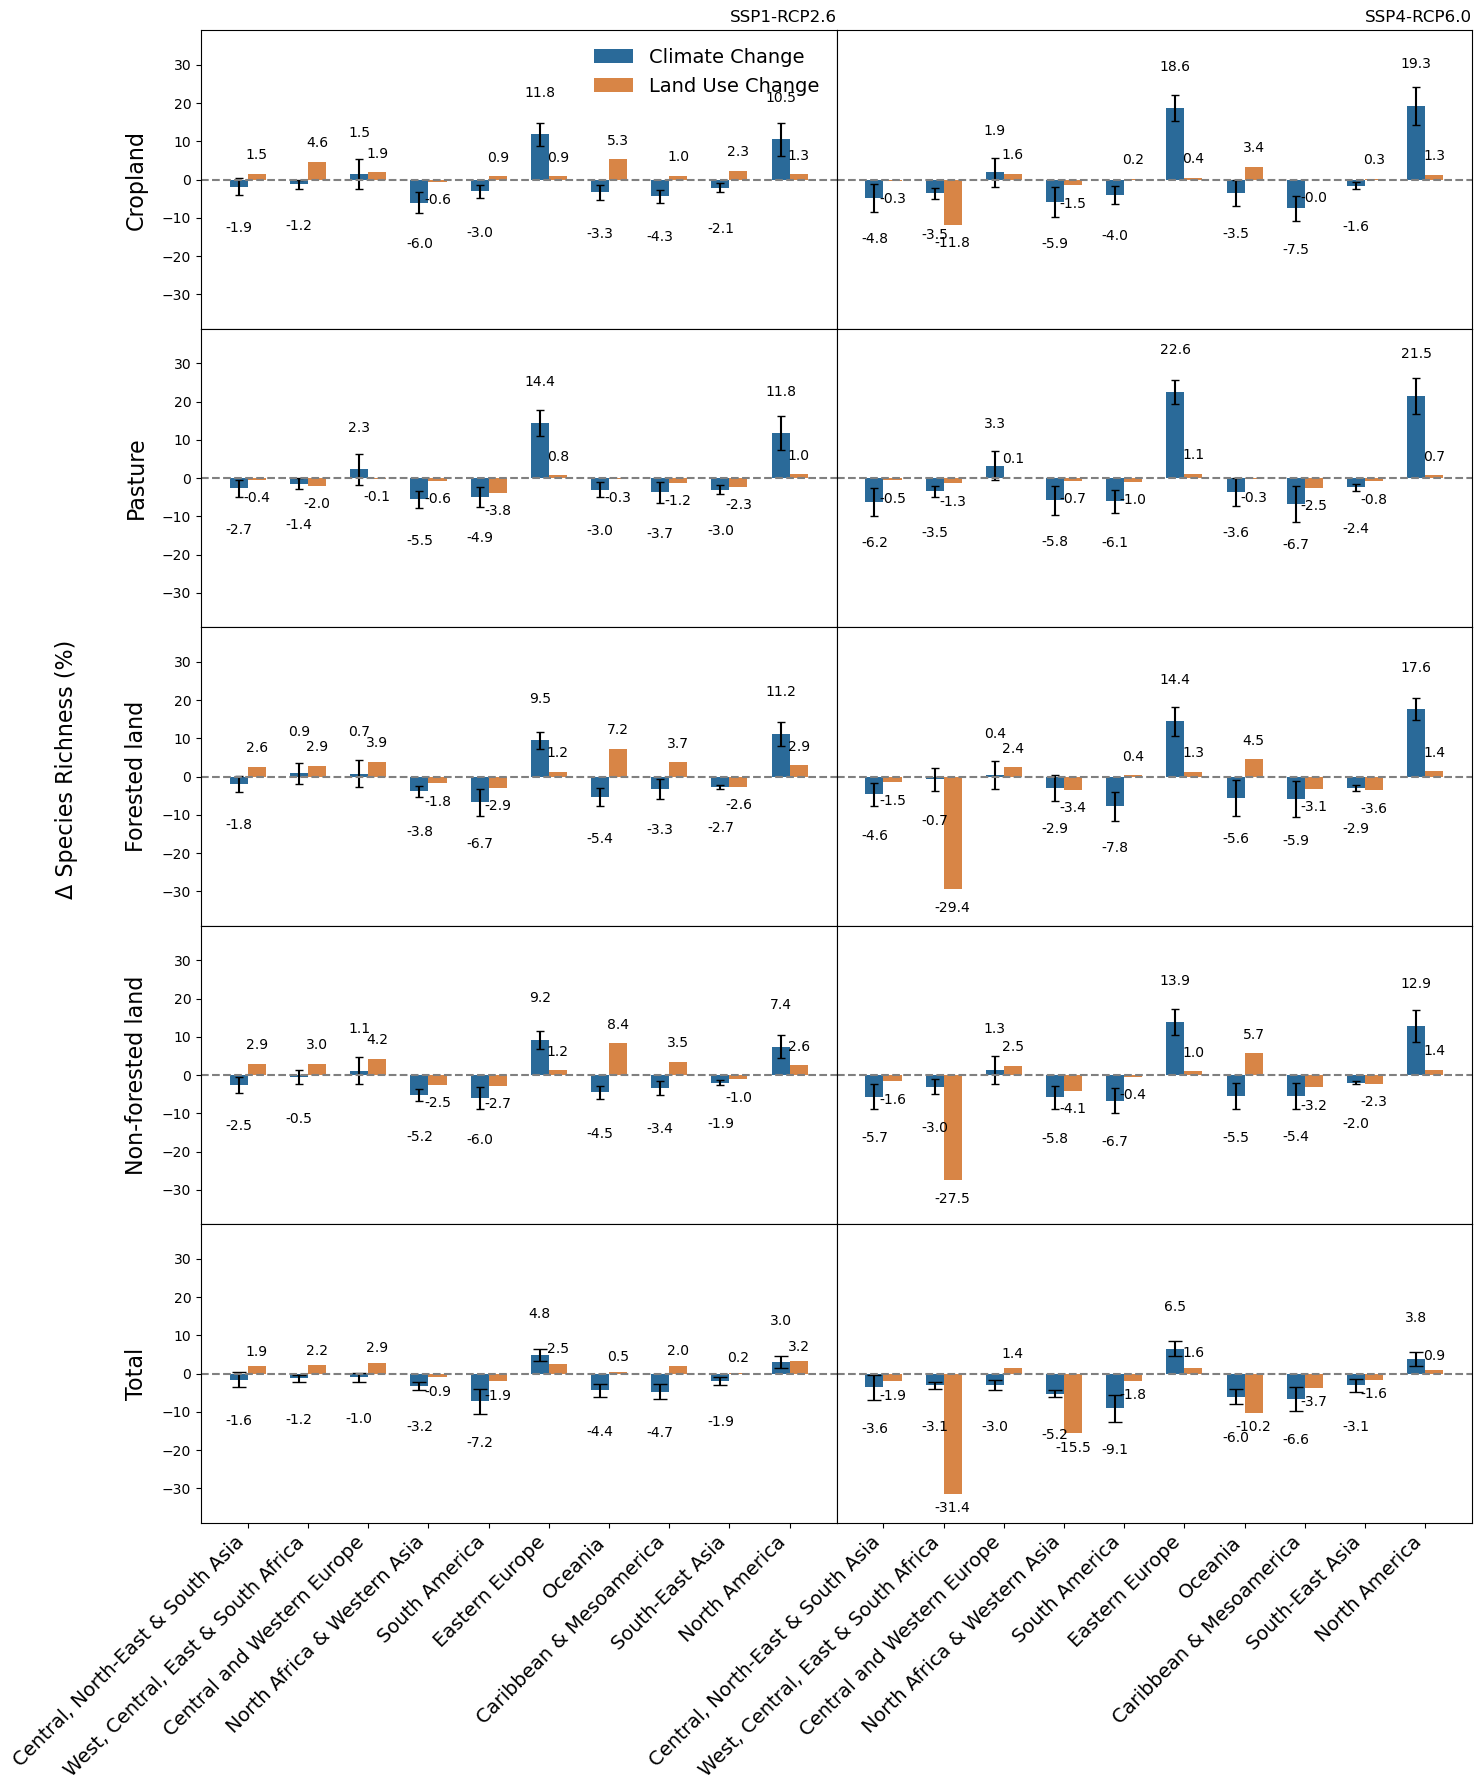

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib as mpl

# Define some parameters for the bar plots
width = 0.3  # Width of the bars
min_threshold = 1e-6
x = np.arange(len(regionlist))  # Assuming regionlist is the list of all regions
scenario_indices = {"rcp26": 'SSP1-RCP2.6', "rcp60": 'SSP4-RCP6.0'}
habitat_indices = {"forest": 'Forested land', "natural_land": 'Non-forested land', "cropland": 'Cropland', "pasture": 'Pasture'}

# Define figure and axes for the matrix of plots, now with 5 rows (4 habitats + 1 total)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))  # Adjust size to fit all rows

# Loop over each habitat and scenario to create the original 4 panels
for i, habitat in enumerate(habitats):
    for j, scenario in enumerate(scenarios):
        ax = axes[i][j]  # Current axes object for plotting

        # Initialize lists for plotting values and errors
        rel_diff_newvalue_means = []
        rel_diff_sumbins = []
        std_dev_newvalue = []

        # Iterate over each region for the specific habitat and scenario
        for region in regionlist:
            # Load required datasets and masks for actual calculations
            oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
            oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
            sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/LandClim_Output/Dispersal4/GAM/Amphibians/EWEMBI/Abavorana_luctuosa_[1146].nc", decode_times=False).to_array().isel(variable=0)
            oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

            # Calculate climate and land use change relative differences
            newvalue_future = mean_over_all_sdms_gcms_fut[scenario][habitat]
            newvalue_hist = mean_over_all_sdms_gcms_hist[scenario][habitat]
            sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat]
            sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat]

            non_zero_mask = sumbin_future != 0
            newvalue_hist_filtered = newvalue_hist.where(newvalue_hist > min_threshold, np.nan)
            difference_climate = xr.where(newvalue_hist != 0, (newvalue_future - newvalue_hist) / newvalue_hist_filtered * 100, 0)
            climate_change = difference_climate.where((difference_climate >= -100) & (difference_climate <= 100))
            climate_change = climate_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)

            sumbin_hist_filtered = sumbin_hist.where(sumbin_hist > min_threshold, np.nan)
            difference_land = (sumbin_future - sumbin_hist_filtered) / sumbin_hist_filtered * 100
            climate_land_change = difference_land.where((difference_land >= -100) & (difference_land <= 100))
            climate_land_change = climate_land_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)

            # Land Use Change (calculated as difference between climate and climate + land use change)
            luc = climate_land_change - climate_change
            rel_diff_newvalue_means.append(climate_change.mean().item())
            rel_diff_sumbins.append(luc.mean().item())

            # Calculate standard deviation
            means_for_std = []
            for sdm in sdms:
                for gcm in gcms:
                    sep_future = mean_newvalue_fut[scenario][habitat][sdm][gcm]
                    sep_hist = mean_newvalue_hist[scenario][habitat][sdm][gcm]
                    sep_hist_filtered = sep_hist.where(sep_hist > min_threshold, np.nan)
                    difference_sep = xr.where(sep_hist != 0, (sep_future - sep_hist) / sep_hist_filtered * 100, 0)
                    relative_change = difference_sep.where((difference_sep >= -100) & (difference_sep <= 100))
                    relative_change = relative_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)
                    means_for_std.append(np.nanmean(relative_change.values))
            std_dev_newvalue.append(np.nanstd(means_for_std))

        # Define x positions for bars
        x1 = x - width / 2  # Positions for "Climate Change" bars
        x2 = x + width / 2  # Positions for "Land Use Change" bars

        # Plot Climate Change and Land Use Change bars
        bars1 = ax.bar(x1, rel_diff_newvalue_means, width, label='Climate Change', color="#2a6a99")
        bars2 = ax.bar(x2, rel_diff_sumbins, width, label='Land Use Change', color="#d88546")

        # Add error bars only to Climate Change
        ax.errorbar(x1, rel_diff_newvalue_means, yerr=std_dev_newvalue, fmt='none', capsize=3, color='black')

        # Add numeric labels to bars with more customized positioning
        for bar in bars1:
            # For positive bars, move label higher above; for negative bars, move label lower
            y_position = bar.get_height() + (9 if bar.get_height() > 0 else -9)  # Larger offset for clarity
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                y_position,
                f"{bar.get_height():.1f}",
                ha='center',
                va='bottom' if bar.get_height() > 0 else 'top',
                fontsize=10
            )

        for bar in bars2:
            # Apply the same logic for the second set of bars
            y_position = bar.get_height() + (3 if bar.get_height() > 0 else -3)  # Larger offset for clarity
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                y_position,
                f"{bar.get_height():.1f}",
                ha='center',
                va='bottom' if bar.get_height() > 0 else 'top',
                fontsize=10
            )


        # Set limits and aesthetics
        ax.set_ylim([-39, 39])
        ax.axhline(y=0, color='gray', linestyle='--')

        # Set y-ticks only for the left column
        if j == 1:
            ax.set_yticks([])

        # Set titles for the first row
        if i == 0:
            ax.set_title(f'{scenario_indices[scenario]}', loc='right')

        # Add legend in the first subplot
        if i == 0 and j == 0:
            ax.legend(frameon=False, fontsize=14)

# Summary data from the provided table
climate_change_data = {
    "SSP1-RCP2.6": [-1.6, -1.2, -1.0, -3.2, -7.2, 4.8, -4.4, -4.7, -1.9, 3.0],
    "SSP4-RCP6.0": [-3.6, -3.1, -3.0, -5.2, -9.1, 6.5, -6.0, -6.6, -3.1, 3.8]
}
climate_land_change_data = {
    "SSP1-RCP2.6": [0.3, 1.0, 1.9, -4.1, -9.1, 7.3, -3.9, -2.7, -1.7, 6.2],
    "SSP4-RCP6.0": [-5.5, -34.5, -1.6, -20.7, -10.9, 8.1, -16.2, -10.3, -4.7, 4.7]
}
# Uncertainty values for "Climate Change"
climate_change_uncertainty = {
    "SSP1-RCP2.6": [1.9, 0.9, 1.2, 1.0, 3.3, 1.6, 1.6, 2.0, 1.0, 1.6],
    "SSP4-RCP6.0": [3.3, 0.9, 1.4, 1.0, 3.5, 1.9, 1.9, 3.2, 1.8, 1.9]
}

# Calculate Land Use Change as the difference between Climate and Land Use Change and Climate Change
land_use_change_data = {
    scenario: [
        climate_land_change_data[scenario][i] - climate_change_data[scenario][i]
        for i in range(len(regionlist))
    ]
    for scenario in scenario_indices.values()
}
# Plot total summary in the fifth row
for j, scenario in enumerate(scenarios):
    ax_totals = axes[4, j]
    climate_means = climate_change_data[scenario_indices[scenario]]
    land_means = land_use_change_data[scenario_indices[scenario]]
    uncertainty = climate_change_uncertainty[scenario_indices[scenario]]

    # Plot bars and add error bars to Climate Change only
    bars1 = ax_totals.bar(x - width / 2, climate_means, width, label='Climate Change', color="#2a6a99", yerr=uncertainty, capsize=5)
    bars2 = ax_totals.bar(x + width / 2, land_means, width, label='Land Use Change', color="#d88546")
    ax_totals.axhline(0, color='gray', linestyle='--')

    # Add numeric labels to bars with more customized positioning
    for bar in bars1:
        # For positive bars, move label higher above; for negative bars, move label lower
        y_position = bar.get_height() + (9 if bar.get_height() > 0 else -9)  # Larger offset for clarity
        ax_totals.text(
            bar.get_x() + bar.get_width() / 2,
            y_position,
            f"{bar.get_height():.1f}",
            ha='center',
            va='bottom' if bar.get_height() > 0 else 'top',
            fontsize=10
        )

    for bar in bars2:
        # Apply the same logic for the second set of bars
        y_position = bar.get_height() + (2 if bar.get_height() > 0 else -2)  # Larger offset for clarity
        ax_totals.text(
            bar.get_x() + bar.get_width() / 2,
            y_position,
            f"{bar.get_height():.1f}",
            ha='center',
            va='bottom' if bar.get_height() > 0 else 'top',
            fontsize=10
        )


    # Set x-ticks and labels for the regions
    ax_totals.set_xticks(x)
    ax_totals.set_xticklabels(regionlist, rotation=45, ha='right', fontsize=14)
    # Define the y-tick range
    y_ticks = np.arange(-30, 31, 10)  # From -30 to +30 with intervals of 10

    # Loop over each subplot and set the y-ticks
    for i in range(5):  # 5 rows
        for j in range(2):  # 2 columns
            axes[i, j].set_yticks(y_ticks)  # Set y-ticks for each subplot
            axes[i, j].set_ylim(-39, 39)  # Ensure y-limits are consistent


# Add habitat labels on the right side of the plot matrix
for i, habitat in enumerate(habitats):
    axes[i, -1].text(-1.12, 0.5, habitat_indices[habitat], transform=axes[i, -1].transAxes, rotation=90, va='center', fontsize=16)
axes[4, -1].text(-1.12, 0.5, "Total", transform=axes[4, -1].transAxes, rotation=90, va='center', fontsize=16)
axes[0, 1].set_yticks([]) 
axes[1, 1].set_yticks([]) 
axes[2, 1].set_yticks([]) 
axes[3, 1].set_yticks([]) 
axes[4, 1].set_yticks([]) # Remove y-ticks from the total panel on the right column

# Add y-axis label for the entire figure
fig.text(0.045, 0.57, 'Δ Species Richness (%)', va='center', rotation='vertical', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)  # Adjust as needed

# Increase the left margin to avoid overlap with y-tick labels


# Display the plot
plt.show()


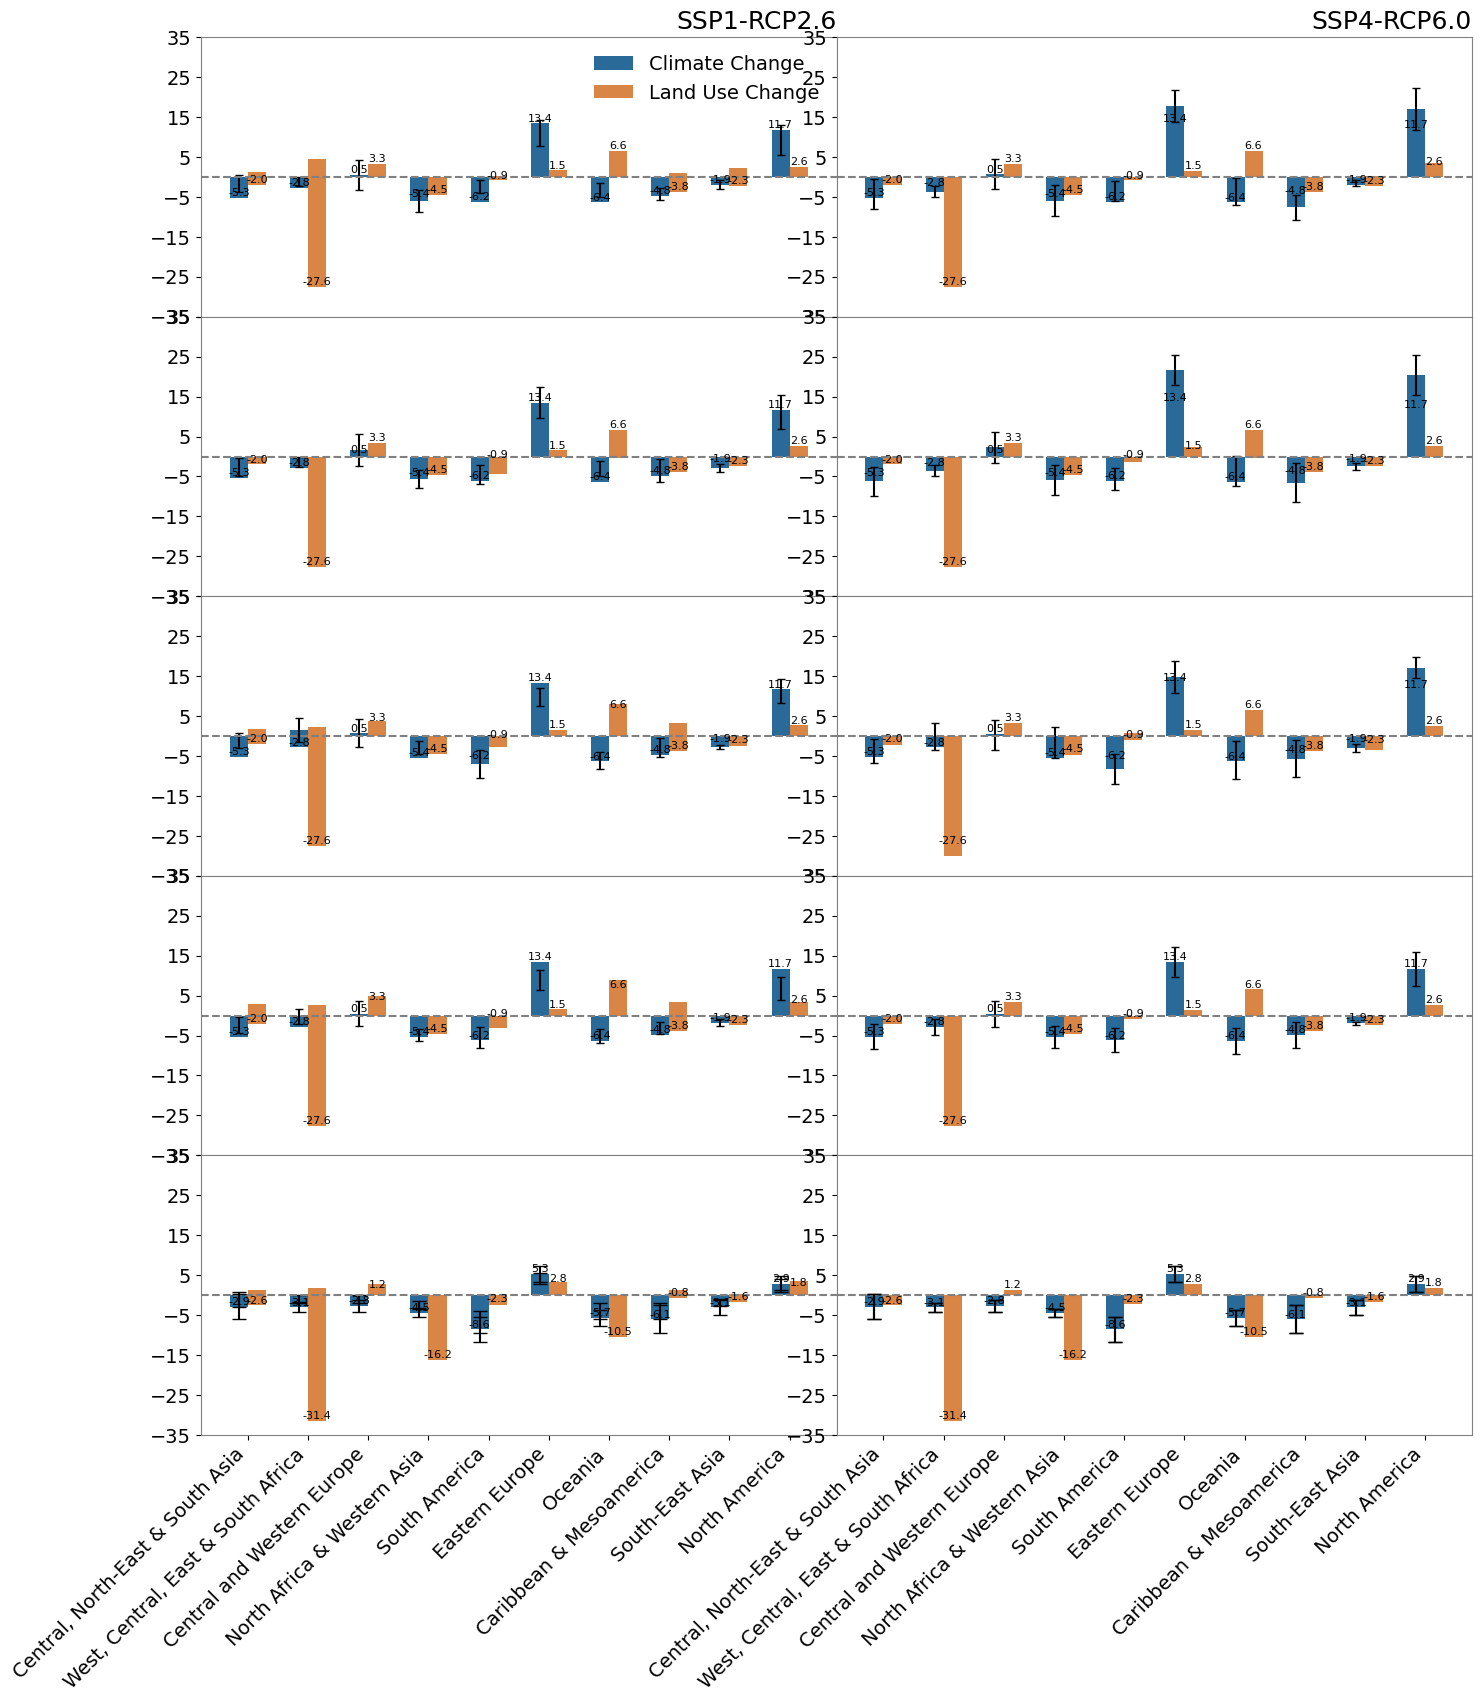

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib as mpl

# Define some parameters for the bar plots
width = 0.3  # Width of the bars
min_threshold = 1e-6
x = np.arange(len(regionlist))  # Assuming regionlist is the list of all regions
scenario_indices = {"rcp26": 'SSP1-RCP2.6', "rcp60": 'SSP4-RCP6.0'}
habitat_indices = {"forest": 'Forested land', "natural_land": 'Non-forested land', "cropland": 'Cropland', "pasture": 'Pasture'}

# Define figure and axes for the matrix of plots, now with 5 rows (4 habitats + 1 total)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))  # Adjust size to fit all rows

# Loop over each habitat and scenario to create the original 4 panels
for i, habitat in enumerate(habitats):
    for j, scenario in enumerate(scenarios):
        ax = axes[i][j]  # Current axes object for plotting

        # Initialize lists for plotting values and errors
        rel_diff_newvalue_means = []
        rel_diff_sumbins = []
        std_dev_newvalue = []

        # Iterate over each region for the specific habitat and scenario
        for region in regionlist:
            # Load required datasets and masks for actual calculations
            oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
            oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
            sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/LandClim_Output/Dispersal4/GAM/Amphibians/EWEMBI/Abavorana_luctuosa_[1146].nc", decode_times=False).to_array().isel(variable=0)
            oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

            # Calculate climate and land use change relative differences
            newvalue_future = mean_over_all_sdms_gcms_fut[scenario][habitat]
            newvalue_hist = mean_over_all_sdms_gcms_hist[scenario][habitat]
            sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat]
            sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat]

            non_zero_mask = sumbin_future != 0
            newvalue_hist_filtered = newvalue_hist.where(newvalue_hist > min_threshold, np.nan)
            difference_climate = xr.where(newvalue_hist != 0, (newvalue_future - newvalue_hist) / newvalue_hist_filtered * 100, 0)
            climate_change = difference_climate.where((difference_climate >= -100) & (difference_climate <= 100))
            climate_change = climate_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)

            sumbin_hist_filtered = sumbin_hist.where(sumbin_hist > min_threshold, np.nan)
            difference_land = (sumbin_future - sumbin_hist_filtered) / sumbin_hist_filtered * 100
            climate_land_change = difference_land.where((difference_land >= -100) & (difference_land <= 100))
            climate_land_change = climate_land_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)

            # Land Use Change (calculated as difference between climate and climate + land use change)
            luc = climate_land_change - climate_change
            rel_diff_newvalue_means.append(climate_change.mean().item())
            rel_diff_sumbins.append(luc.mean().item())

            # Calculate standard deviation
            means_for_std = []
            for sdm in sdms:
                for gcm in gcms:
                    sep_future = mean_newvalue_fut[scenario][habitat][sdm][gcm]
                    sep_hist = mean_newvalue_hist[scenario][habitat][sdm][gcm]
                    sep_hist_filtered = sep_hist.where(sep_hist > min_threshold, np.nan)
                    difference_sep = xr.where(sep_hist != 0, (sep_future - sep_hist) / sep_hist_filtered * 100, 0)
                    relative_change = difference_sep.where((difference_sep >= -100) & (difference_sep <= 100))
                    relative_change = relative_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)
                    means_for_std.append(np.nanmean(relative_change.values))
            std_dev_newvalue.append(np.nanstd(means_for_std))

        # Define x positions for bars
        x1 = x - width / 2  # Positions for "Climate Change" bars
        x2 = x + width / 2  # Positions for "Land Use Change" bars

        # Plot Climate Change and Land Use Change bars
        ax.bar(x1, rel_diff_newvalue_means, width, label='Climate Change', color="#2a6a99")
        ax.bar(x2, rel_diff_sumbins, width, label='Land Use Change', color="#d88546")

        # Add error bars only to Climate Change
        ax.errorbar(x1, rel_diff_newvalue_means, yerr=std_dev_newvalue, fmt='none', capsize=3, color='black')

        # Set limits and aesthetics
        ax.set_ylim([-35, 35])
        ax.axhline(y=0, color='gray', linestyle='--')



        # Set y-ticks only for the left column
        if j == 1:
            ax.set_yticks([])

        # Set titles for the first row
        if i == 0:
            ax.set_title(f'{scenario_indices[scenario]}', loc='right')

        # Add legend in the first subplot
        if i == 0 and j == 0:
            ax.legend(frameon=False, fontsize=14)

# Summary data from the provided table
climate_change_data = {
    "SSP1-RCP2.6": [-1.0, -0.8, -1.0, -2.4, -6.7, 4.1, -4.0, -4.0, -1.9, 2.6],
    "SSP4-RCP6.0": [-2.9, -3.1, -2.8, -4.5, -8.6, 5.3, -5.7, -6.1, -3.1, 2.9]
}
climate_land_change_data = {
    "SSP1-RCP2.6": [0.3, 1.0, 1.9, -4.1, -9.1, 7.3, -3.9, -2.7, -1.7, 6.2],
    "SSP4-RCP6.0": [-5.5, -34.5, -1.6, -20.7, -10.9, 8.1, -16.2, -6.9, -4.7, 4.7]
}
# Uncertainty values for "Climate Change"
climate_change_uncertainty = {
    "SSP1-RCP2.6": [1.9, 0.9, 1.1, 0.9, 2.8, 1.4, 1.9, 1.9, 0.9, 1.4],
    "SSP4-RCP6.0": [3.1, 1.1, 1.5, 1.1, 3.2, 2.0, 2.0, 3.5, 1.8, 2.0]
}

# Calculate Land Use Change as the difference between Climate and Land Use Change and Climate Change
land_use_change_data = {
    scenario: [
        climate_land_change_data[scenario][i] - climate_change_data[scenario][i]
        for i in range(len(regions))
    ]
    for scenario in scenario_indices.values()
}
# Plot total summary in the fifth row
for j, scenario in enumerate(scenarios):
    ax_totals = axes[4, j]
    climate_means = climate_change_data[scenario_indices[scenario]]
    land_means = land_use_change_data[scenario_indices[scenario]]
    uncertainty = climate_change_uncertainty[scenario_indices[scenario]]

    # Plot bars and add error bars to Climate Change only
    ax_totals.bar(x - width / 2, climate_means, width, label='Climate Change', color="#2a6a99", yerr=uncertainty, capsize=5)
    ax_totals.bar(x + width / 2, land_means, width, label='Land Use Change', color="#d88546")
    ax_totals.axhline(0, color='gray', linestyle='--')

    # Set x-ticks and labels for the regions
    ax_totals.set_xticks(x)
    ax_totals.set_xticklabels(regionlist, rotation=45, ha='right', fontsize=14)
    ax.set_ylim([-35, 35])

# Set consistent y-axis limits and ticks
y_min, y_max = -35, 35  # Adjust these limits as needed
y_ticks = np.arange(y_min, y_max + 10, 10)  # Define y-ticks at regular intervals

# Loop over each habitat and scenario to create the original 4 panels and add numbers to bars
for i, habitat in enumerate(habitats):
    for j, scenario in enumerate(scenarios):
        ax = axes[i][j]  # Current axes object for plotting

        # Set y-limits and ticks
        ax.set_ylim(y_min, y_max)
        ax.set_yticks(y_ticks)

        # Plot bars and add labels for each value
        bars1 = ax.bar(x - width / 2, rel_diff_newvalue_means, width, label='Climate Change', color="#2a6a99")
        bars2 = ax.bar(x + width / 2, rel_diff_sumbins, width, label='Land Use Change', color="#d88546")

        # Add text labels above each bar
        for bar in bars1:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{bar.get_height():.1f}",
                ha='center',
                va='bottom',
                fontsize=8
            )
        for bar in bars2:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{bar.get_height():.1f}",
                ha='center',
                va='bottom',
                fontsize=8
            )

# Ensure consistent y-axis on the total summary (fifth row)
for j, scenario in enumerate(scenarios):
    ax_totals = axes[4, j]
    ax_totals.set_ylim(y_min, y_max)
    ax_totals.set_yticks(y_ticks)

    # Plot bars and add labels for each value
    bars1 = ax_totals.bar(x - width / 2, climate_means, width, label='Climate Change', color="#2a6a99", yerr=uncertainty, capsize=5)
    bars2 = ax_totals.bar(x + width / 2, land_means, width, label='Land Use Change', color="#d88546")

    # Add text labels above each bar
    for bar in bars1:
        ax_totals.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{bar.get_height():.1f}",
            ha='center',
            va='bottom',
            fontsize=8
        )
    for bar in bars2:
        ax_totals.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{bar.get_height():.1f}",
            ha='center',
            va='bottom',
            fontsize=8
        )

# Adjust layout to prevent label overlap
plt.tight_layout()
plt.subplots_adjust(bottom=0.2, wspace=0, hspace=0)  # Increase bottom if needed

# Display the plot
plt.show()


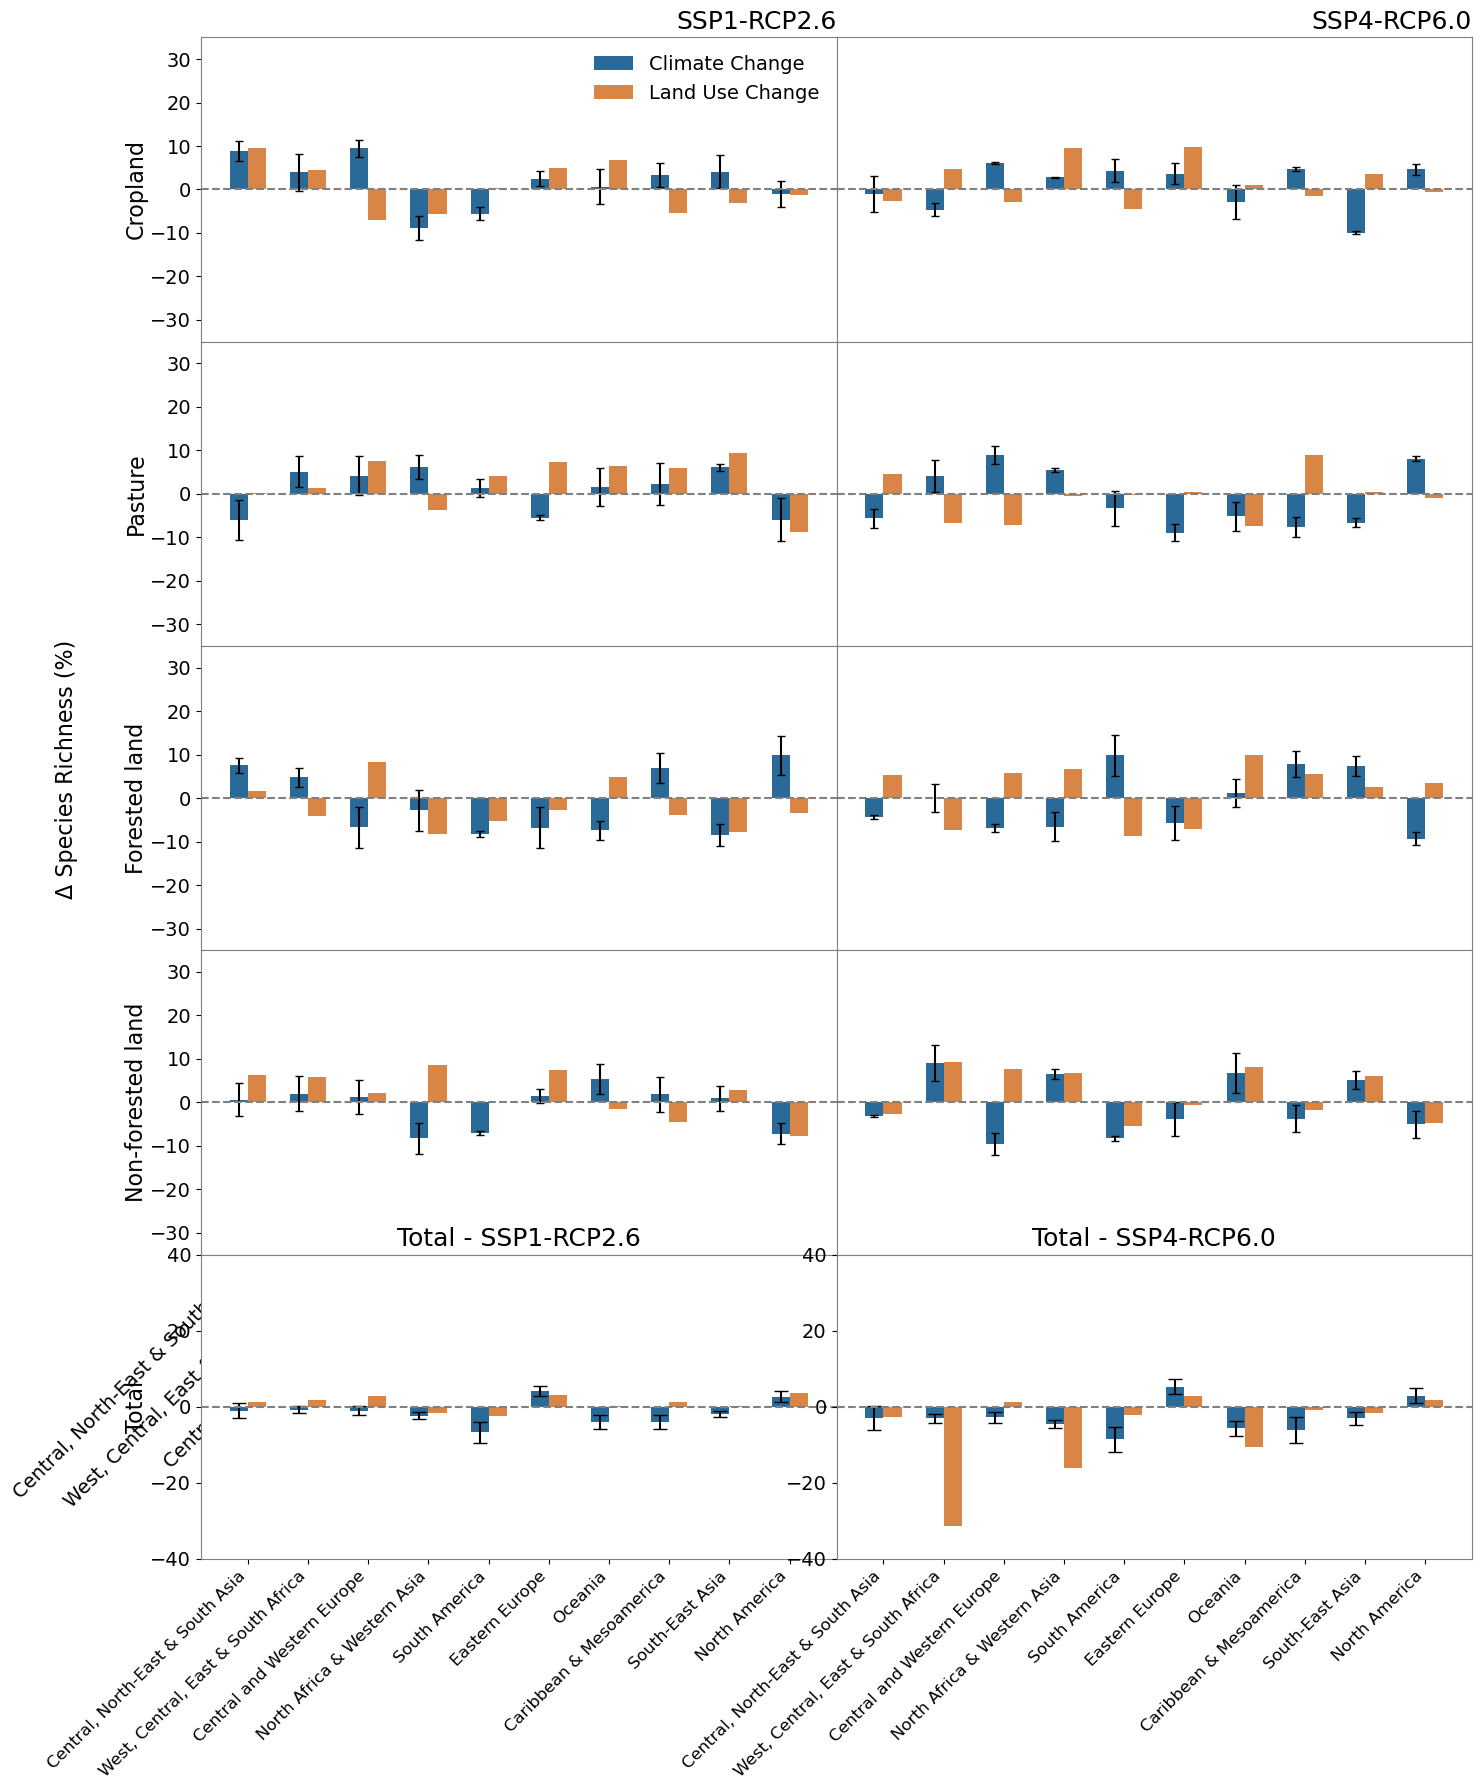

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib as mpl

# Define parameters for bar plots
width = 0.3  # Width of the bars
min_threshold = 1e-6
x = np.arange(len(regionlist))  # Assuming regionlist is the list of all regions
scenario_indices = {"rcp26": 'SSP1-RCP2.6', "rcp60": 'SSP4-RCP6.0'}
habitat_indices = {"forest": 'Forested land', "natural_land": 'Non-forested land', "cropland": 'Cropland', "pasture": 'Pasture'}

# Define figure and axes for the matrix of plots, with 5 rows now (4 habitats + 1 total)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))  # Adjust size to fit all rows

# Loop over each habitat and scenario to create the original 4 panels
for i, habitat in enumerate(habitats):
    for j, scenario in enumerate(scenarios):
        ax = axes[i][j]  # Current axes object for plotting

        # Initialize lists for plotting values and errors
        rel_diff_newvalue_means = []
        rel_diff_sumbins = []
        std_dev_newvalue = []

        # Iterate over each region for the specific habitat and scenario
        for region in regionlist:
            # Placeholder values; replace these with actual data calculations
            rel_diff_newvalue_mean = np.random.uniform(-10, 10)  # Replace with actual calculation
            rel_diff_sumbin = np.random.uniform(-10, 10)         # Replace with actual calculation
            std_dev_newvalue_region = np.random.uniform(0, 5)    # Replace with actual calculation

            # Append calculated values
            rel_diff_newvalue_means.append(rel_diff_newvalue_mean)
            rel_diff_sumbins.append(rel_diff_sumbin)
            std_dev_newvalue.append(std_dev_newvalue_region)

        # Define x positions for bars
        x1 = x - width / 2  # Positions for "Climate Change" bars
        x2 = x + width / 2  # Positions for "Land Use Change" bars

        # Plot Climate Change and Land Use Change bars
        ax.bar(x1, rel_diff_newvalue_means, width, label='Climate Change', color="#2a6a99")
        ax.bar(x2, rel_diff_sumbins, width, label='Land Use Change', color="#d88546")

        # Add error bars only to Climate Change
        ax.errorbar(x1, rel_diff_newvalue_means, yerr=std_dev_newvalue, fmt='none', capsize=3, color='black')

        # Set limits and aesthetics
        ax.set_ylim([-35, 35])
        ax.axhline(y=0, color='gray', linestyle='--')

        # Configure x-tick labels for the last row of habitats only
        if i == len(habitats) - 1:
            ax.set_xticks(x)
            ax.set_xticklabels(regionlist, rotation=45, ha='right', fontsize=14)
        else:
            ax.set_xticks([])  # Hide x-ticks for other rows

        # Set y-ticks only for the left column
        if j == 1:
            ax.set_yticks([])

        # Set titles for the first row
        if i == 0:
            ax.set_title(f'{scenario_indices[scenario]}', loc='right')

        # Add legend in the first subplot
        if i == 0 and j == 0:
            ax.legend(frameon=False, fontsize=14)

# Fifth row: Total summary for each scenario
# Data for Climate Change, Climate and Land Use Change, and Uncertainty
climate_change_data = {
    "SSP1-RCP2.6": [-1.0, -0.8, -1.0, -2.4, -6.7, 4.1, -4.0, -4.0, -1.9, 2.6],
    "SSP4-RCP6.0": [-2.9, -3.1, -2.8, -4.5, -8.6, 5.3, -5.7, -6.1, -3.1, 2.9]
}
climate_land_change_data = {
    "SSP1-RCP2.6": [0.3, 1.0, 1.9, -4.1, -9.1, 7.3, -3.9, -2.7, -1.7, 6.2],
    "SSP4-RCP6.0": [-5.5, -34.5, -1.6, -20.7, -10.9, 8.1, -16.2, -6.9, -4.7, 4.7]
}
climate_change_uncertainty = {
    "SSP1-RCP2.6": [1.9, 0.9, 1.1, 0.9, 2.8, 1.4, 1.9, 1.9, 0.9, 1.4],
    "SSP4-RCP6.0": [3.1, 1.1, 1.5, 1.1, 3.2, 2.0, 2.0, 3.5, 1.8, 2.0]
}

# Calculate Land Use Change as the difference between Climate and Climate + Land Use Change
land_use_change_data = {
    scenario: [
        climate_land_change_data[scenario][i] - climate_change_data[scenario][i]
        for i in range(len(regionlist))
    ]
    for scenario in scenario_indices.values()
}

# Plot total summary in the fifth row
for j, scenario in enumerate(scenarios):
    ax_totals = axes[4, j]
    climate_means = climate_change_data[scenario_indices[scenario]]
    land_means = land_use_change_data[scenario_indices[scenario]]
    uncertainty = climate_change_uncertainty[scenario_indices[scenario]]

    # Plot bars and add error bars to Climate Change only
    ax_totals.bar(x - width / 2, climate_means, width, label='Climate Change', color="#2a6a99", yerr=uncertainty, capsize=5)
    ax_totals.bar(x + width / 2, land_means, width, label='Land Use Change', color="#d88546")
    ax_totals.axhline(0, color='gray', linestyle='--')

    # Set x-ticks and labels for the regions
    ax_totals.set_xticks(x)
    ax_totals.set_xticklabels(regionlist, rotation=45, ha='right', fontsize=12)
    ax_totals.set_ylim([-40, 40])
    ax_totals.set_title(f"Total - {scenario_indices[scenario]}")

# Add habitat labels on the right side of the plot matrix
for i, habitat in enumerate(habitats):
    axes[i, -1].text(-1.12, 0.5, habitat_indices[habitat], transform=axes[i, -1].transAxes, rotation=90, va='center', fontsize=16)
axes[4, -1].text(-1.12, 0.5, "Total", transform=axes[4, -1].transAxes, rotation=90, va='center', fontsize=16)

# Add y-axis label for the entire figure
fig.text(0.045, 0.57, 'Δ Species Richness (%)', va='center', rotation='vertical', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)  # Adjust as needed

# Save the figure
plt.savefig("/storage/homefs/ch21o450/scripts/climate_Hari_etal_inprep/functions/figures/main_figures/Figure_3_with_totals.png")
plt.show()


In [54]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib as mpl

# Define some parameters for the bar plots
width = 0.3  # the width of the bars
min_threshold = 1e-6
# Create the x-axis positions for the bars
x = np.arange(len(regionlist)) / 2
scenario_indices={"rcp26": 'SSP1-RCP2.6', "rcp60": 'SSP4-RCP6.0'}
habitat_indices={"forest": 'forested land', "natural_land": 'non-forested land',"cropland": 'cropland',"pasture": 'pasture'}


# Initialize an empty DataFrame
data = []


# Loop over each habitat and scenario to create each subplot
for i, habitat in enumerate(habitats):
    for j, scenario in enumerate(scenarios):
        ax = axes[i][j]  # This is the current axes object to plot on


        # Initialize lists for plotting
        rel_diff_newvalue_means = []
        rel_diff_sumbins = []
        std_dev_newvalue = []



        # Iterate over each region for the specific habitat and scenario
        for region in regionlist:
        
            oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
            oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
            sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
            oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')
            # Calculate th
            newvalue_future = mean_over_all_sdms_gcms_fut[scenario][habitat]
            newvalue_hist = mean_over_all_sdms_gcms_hist[scenario][habitat]
            sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat]
            sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat]



            # Calculate the relative difference safely
            non_zero_mask = sumbin_future != 0
            newvalue_hist_filtered = newvalue_hist.where(newvalue_hist > min_threshold, np.nan)
            difference = xr.where(newvalue_hist != 0, (newvalue_future - newvalue_hist) / newvalue_hist_filtered * 100, 0)
            climate_change = difference.where((difference >= -100) & (difference <= 100))

            climate_change = climate_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            sumbin_hist_filtered = sumbin_hist.where(sumbin_hist > min_threshold, np.nan)
            difference = (sumbin_future - sumbin_hist_filtered) / sumbin_hist_filtered * 100
            climate_land_change = difference.where((difference >= -100) & (difference <= 100))

            climate_land_change = climate_land_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            luc = climate_land_change - climate_change

            rel_diff_newvalue_mean = climate_change.mean()
            rel_diff_sumbin = luc.mean()

            # Append the values to the list
            rel_diff_newvalue_means.append(rel_diff_newvalue_mean)
            rel_diff_sumbins.append(rel_diff_sumbin)


            means_for_std = []

            for sdm in sdms:
                for gcm in gcms:

                    sep_future = mean_newvalue_fut[scenario][habitat][sdm][gcm]
                    sep_hist = mean_newvalue_hist[scenario][habitat][sdm][gcm]
                    sep_hist_filtered = sep_hist.where(sep_hist > min_threshold, np.nan)
                    difference = xr.where(sep_hist != 0, (sep_future - sep_hist) / sep_hist_filtered * 100, 0)
                    relative_change = difference.where((difference >= -100) & (difference <= 100))
                    relative_change = relative_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)

                    # Calculate the mean for this SDM and GCM
                    mean_relative_change = np.nanmean(relative_change.values)
                    means_for_std.append(mean_relative_change)

            # Compute the standard deviation of these means
            std_dev_newvalue_region = np.nanstd(means_for_std)
            std_dev_newvalue.append(std_dev_newvalue_region)

            ax.set_ylim([-35, 35])
  
        for k, region in enumerate(regionlist):
            row = {
                'Region': region,
                'Habitat': habitat_indices[habitat],
                'Scenario': scenario_indices[scenario],
                'Mean Relative Difference': round(float(rel_diff_newvalue_means[k]), 3),
                'Mean Land Use Change': round(float(rel_diff_sumbins[k]), 3),
                'Standard Deviation': round(std_dev_newvalue[k], 3)
            }
            data.append(row)


# Create the DataFrame from the accumulated data
df = pd.DataFrame(data)

# Set the index of the DataFrame to the region names if desired
df.set_index('Region', inplace=False)


df.to_csv("/storage/homefs/ch21o450/scripts/climate_Hari_etal_inprep/functions/figures/main_figures/summary_data.csv", index=False)

In [51]:
mean_over_all_sdms_gcms_fut

{'rcp26': {'cropland': <xarray.DataArray 'newvalue' (lat: 360, lon: 720)>
  array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]])
  Coordinates:
    * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
    * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75,
  'pasture': <xarray.DataArray 'newvalue' (lat: 360, lon: 720)>
  array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]])
  Coordinates:
    * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
    * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75,
  'for

In [47]:
 round(float(rel_diff_newvalue_means[region]),3)

TypeError: list indices must be integers or slices, not str

In [17]:
round(float(rel_diff_newvalue_means[1]),2)

IndexError: list index out of range

In [9]:

# Now, after all loops have completed, create the DataFrame
data = []  # Initialize the data list outside the loops if not already done
for region_index, region in enumerate(regionlist):
    data.append({
        "Region": region,
        "Habitat": habitat_indices[habitat],
        "Scenario": scenario_indices[scenario],
        "Mean Climate Change": rel_diff_newvalue_means[region_index],
        "Mean Land Use Change": rel_diff_sumbins[region_index],
        "Std Dev New Value": std_dev_newvalue[region_index]
    })

df = pd.DataFrame(data)
df.to_csv("/storage/homefs/ch21o450/scripts/climate_Hari_etal_inprep/functions/figures/climate_land_use_change_summary.csv", index=False)
print(df)

                               Region            Habitat     Scenario  \
0    Central, North-East & South Asia  Non-forested land  SSP4-RCP6.0   
1  West, Central, East & South Africa  Non-forested land  SSP4-RCP6.0   
2          Central and Western Europe  Non-forested land  SSP4-RCP6.0   
3         North Africa & Western Asia  Non-forested land  SSP4-RCP6.0   
4                       South America  Non-forested land  SSP4-RCP6.0   
5                      Eastern Europe  Non-forested land  SSP4-RCP6.0   
6                             Oceania  Non-forested land  SSP4-RCP6.0   
7             Caribbean & Mesoamerica  Non-forested land  SSP4-RCP6.0   
8                     South-East Asia  Non-forested land  SSP4-RCP6.0   
9                       North America  Non-forested land  SSP4-RCP6.0   

   Mean Climate Change  Mean Land Use Change  Std Dev New Value  
0            -5.676730             -1.632248           3.279399  
1            -2.976015            -27.483514           1.911845 

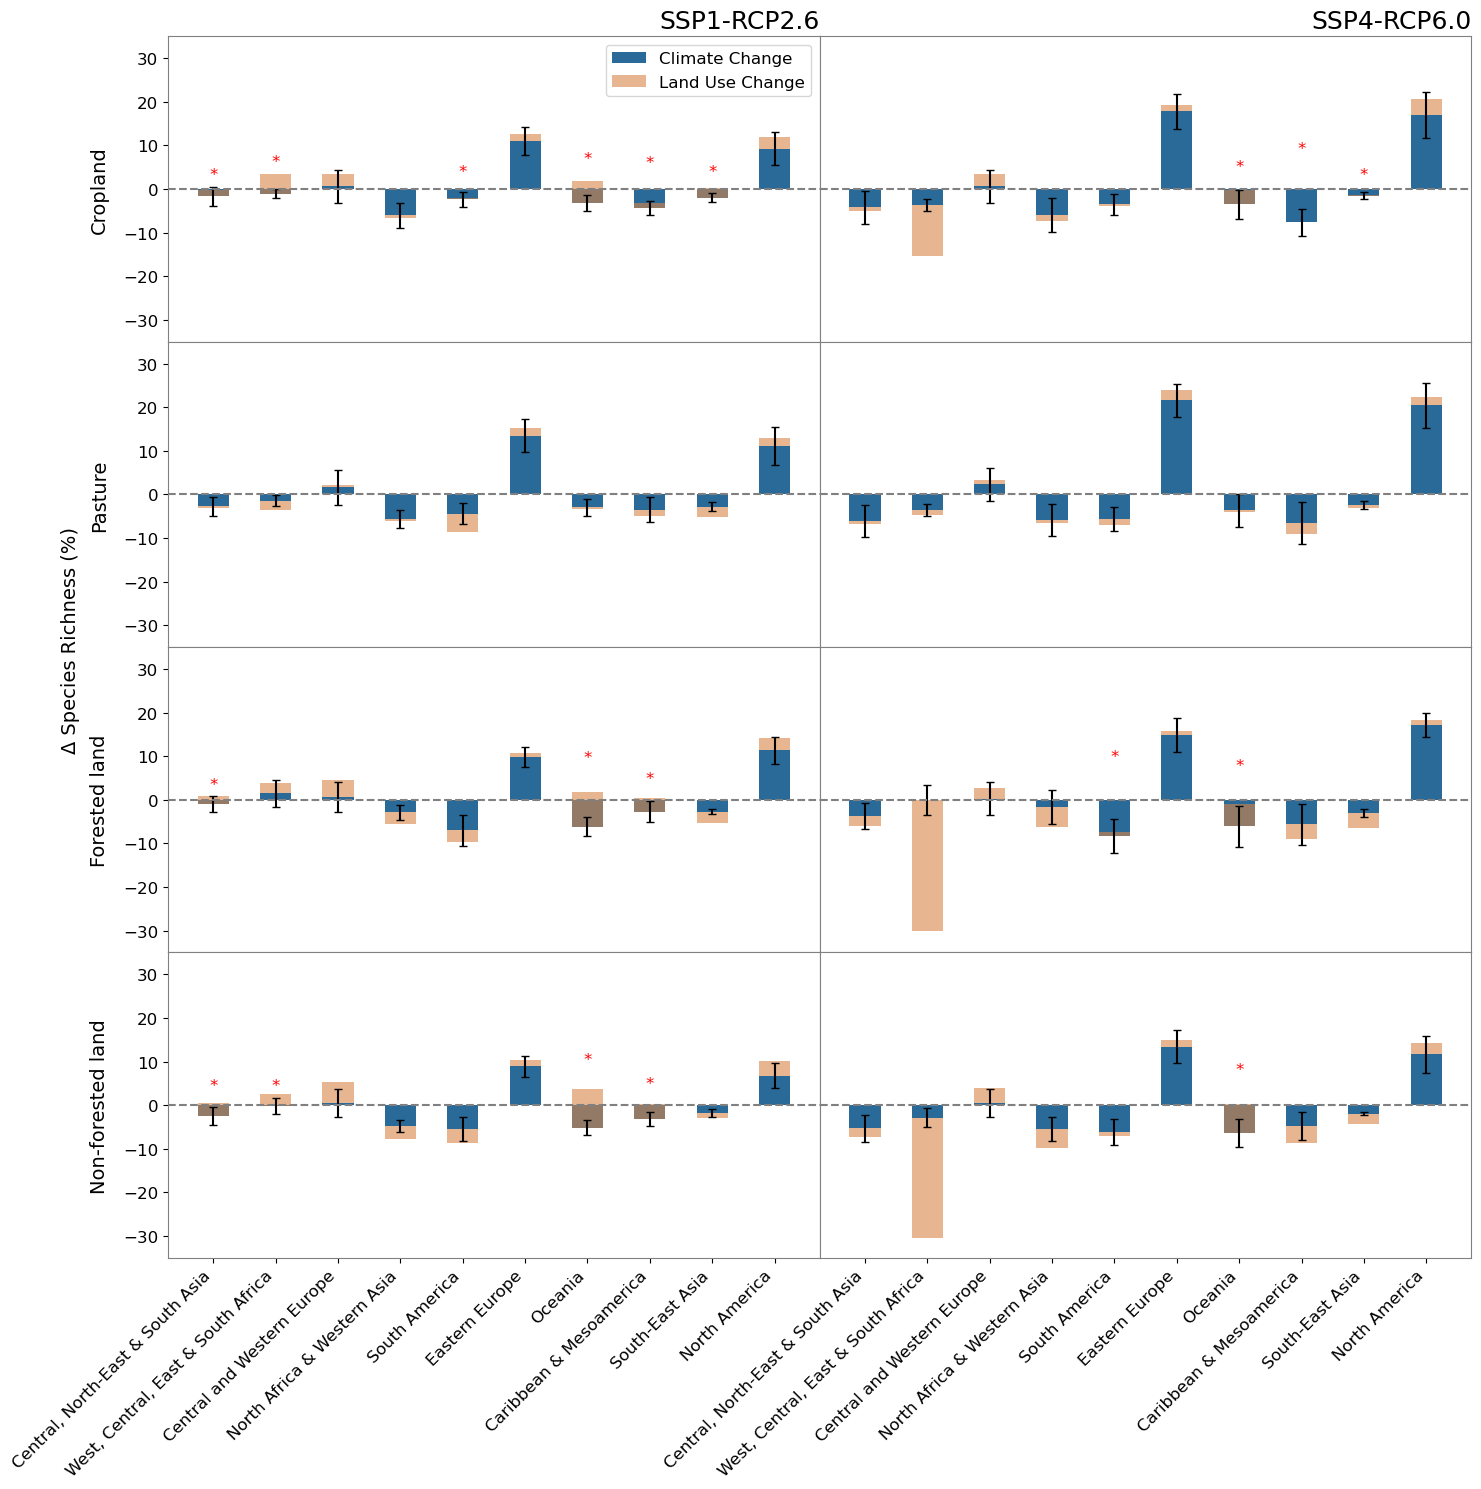

In [12]:

# Define some parameters for the bar plots
width = 0.3  # the width of the bars
min_threshold = 1e-6
# Create the x-axis positions for the bars
x = np.arange(len(regionlist)) / 2
scenario_indices={"rcp26": 'SSP1-RCP2.6', "rcp60": 'SSP4-RCP6.0'}
habitat_indices={"forest": 'Forested land', "natural_land": 'Non-forested land',"cropland": 'Cropland',"pasture": 'Pasture'}


# Create the x-axis positions for the bars
x = np.arange(len(regionlist))  # Assuming regionlist is the list of all regions
def set_plot_param():
    """Set my own customized plotting parameters"""
    mpl.rc('axes', edgecolor='grey')
    mpl.rc('axes', labelcolor='black')
    mpl.rc('xtick', color='black')
    mpl.rc('xtick', labelsize=12)
    mpl.rc('ytick', color='black')
    mpl.rc('ytick', labelsize=12)
    mpl.rc('axes', titlesize=18)
    mpl.rc('axes', labelsize=12)
    mpl.rc('legend', fontsize='large')
    mpl.rc('text', color='black')

# Call the function to set the plot parameters
set_plot_param()
# Define figure and axes for the matrix of plots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))  # Adjust the size as needed

# Loop over each habitat and scenario to create each subplot
for i, habitat in enumerate(habitats):
    for j, scenario in enumerate(scenarios):
        ax = axes[i][j]  # This is the current axes object to plot on

        # Initialize lists for plotting
        rel_diff_newvalue_means = []
        rel_diff_sumbins = []
        std_dev_newvalue = []

        # Iterate over each region for the specific habitat and scenario
        for region in regionlist:
            oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
            oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
            sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
            oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

            # Calculate th
            newvalue_future = mean_over_all_sdms_gcms_fut[scenario][habitat]
            newvalue_hist = mean_over_all_sdms_gcms_hist[scenario][habitat]
            sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat]
            sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat]



            # Calculate the relative difference safely
            non_zero_mask = sumbin_future != 0
            newvalue_hist_filtered = newvalue_hist.where(newvalue_hist > min_threshold, np.nan)
            difference = xr.where(newvalue_hist != 0, (newvalue_future - newvalue_hist) / newvalue_hist_filtered * 100, 0)
            climate_change = difference.where((difference >= -100) & (difference <= 100))

            climate_change = climate_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            sumbin_hist_filtered = sumbin_hist.where(sumbin_hist > min_threshold, np.nan)
            difference = (sumbin_future - sumbin_hist_filtered) / sumbin_hist_filtered * 100
            climate_land_change = difference.where((difference >= -100) & (difference <= 100))

            climate_land_change = climate_land_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            luc = climate_land_change - climate_change

            rel_diff_newvalue_mean = climate_change.mean()
            rel_diff_sumbin = luc.mean()

            # Append the values to the list
            rel_diff_newvalue_means.append(rel_diff_newvalue_mean)
            rel_diff_sumbins.append(rel_diff_sumbin)


            means_for_std = []

            for sdm in sdms:
                for gcm in gcms:

                    sep_future = mean_newvalue_fut[scenario][habitat][sdm][gcm]
                    sep_hist = mean_newvalue_hist[scenario][habitat][sdm][gcm]
                    sep_hist_filtered = sep_hist.where(sep_hist > min_threshold, np.nan)
                    difference = xr.where(sep_hist != 0, (sep_future - sep_hist) / sep_hist_filtered * 100, 0)
                    relative_change = difference.where((difference >= -100) & (difference <= 100))
                    relative_change = relative_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)

                    # Calculate the mean for this SDM and GCM
                    mean_relative_change = np.nanmean(relative_change.values)
                    means_for_std.append(mean_relative_change)

            # Compute the standard deviation of these means
            std_dev_newvalue_region = np.nanstd(means_for_std)
            std_dev_newvalue.append(std_dev_newvalue_region)

        total_heights = np.array(rel_diff_newvalue_means) + np.array(rel_diff_sumbins)

        # Plotting the bars
        width = 0.5 # the width of the bars

        # Plotting the bars with alpha for transparency
        ax.bar(x, rel_diff_newvalue_means, width, label='Climate Change', color="#2a6a99")
        ax.bar(x, rel_diff_sumbins, width, bottom=rel_diff_newvalue_means, label='Land Use Change', color="#d88546", alpha=0.6)
        

        for idx, (value1, value2) in enumerate(zip(rel_diff_newvalue_means, rel_diff_sumbins)):
            if (value1 > 0 and value2 < 0) or (value1 < 0 and value2 > 0):
                # Calculating where the asterisk should be placed
                # If they are opposite signs, we consider the 'overlap' at the higher absolute value
                overlap_height = max(abs(value1), abs(value2))
                ax.text(x[idx], overlap_height, '*', ha='center', va='bottom', fontsize=12, color='red')



        # Adding error bars
        ax.errorbar(x,rel_diff_newvalue_means, yerr=std_dev_newvalue, fmt='none', capsize=3, color='black')

        ax.set_ylim([-35, 35])
        ax.axhline(y=0, color='gray', linestyle='--')
        # If this is the last row, set the x-tick labels
        if i == len(habitats) - 1:
            ax.set_xticks(x)
            ax.set_xticklabels(regionlist, rotation=45, ha='right')
        else:
            ax.set_xticks([])  # No x-tick labels for other rows

        # If this is the first column, set the y-label

            
        if j == 1:
            ax.set_yticks([])


        # Set the title for the top row
        if i == 0:
            ax.set_title(f'{scenario_indices[scenario]}',loc='right')

        # Add the legend only for the first subplot or as per your preference
        if i == 0 and j == 0:
            ax.legend()

# Add the habitat labels on the right side of the plot matrix
for i, habitat in enumerate(habitats):
    axes[i, -1].text(-1.12, 0.5, habitat_indices[habitat], transform=axes[i, -1].transAxes, rotation=90, va='center', fontsize=14)
fig.text(0.05, 0.57, 'Δ Species Richness (%)', va='center', rotation='vertical', fontsize=14)

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)  # Adjust this value as needed
#plt.savefig("/storage/homefs/ch21o450/scripts/climate_Hari_etal_inprep/functions/figures/main_figures/Figure_3")
# Show the plot
plt.show()

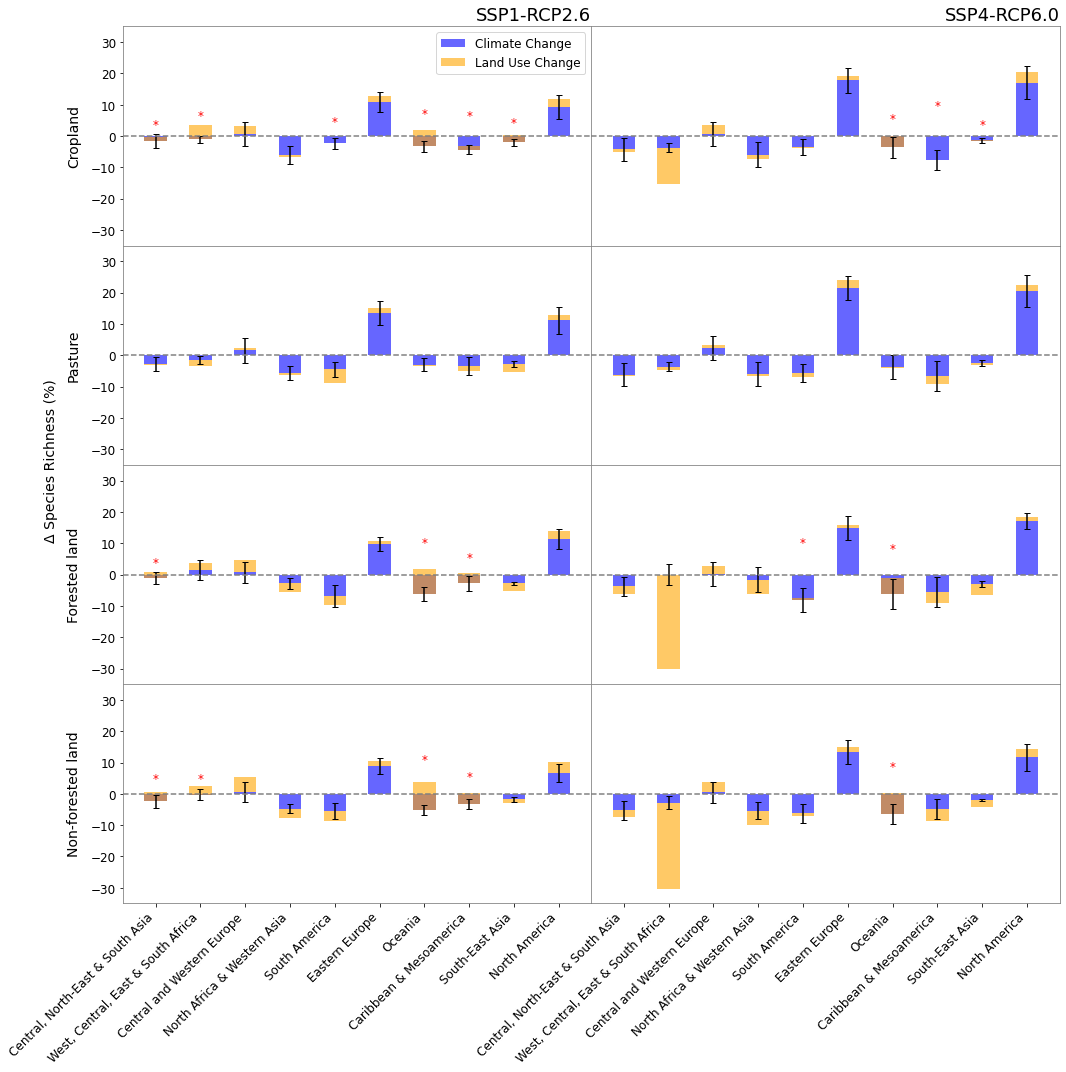

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib as mpl

# Define some parameters for the bar plots
width = 0.3  # the width of the bars
min_threshold = 1e-6
# Create the x-axis positions for the bars
x = np.arange(len(regionlist)) / 2
scenario_indices={"rcp26": 'SSP1-RCP2.6', "rcp60": 'SSP4-RCP6.0'}
habitat_indices={"forest": 'Forested land', "natural_land": 'Non-forested land',"cropland": 'Cropland',"pasture": 'Pasture'}


# Create the x-axis positions for the bars
x = np.arange(len(regionlist))  # Assuming regionlist is the list of all regions
def set_plot_param():
    """Set my own customized plotting parameters"""
    mpl.rc('axes', edgecolor='grey')
    mpl.rc('axes', labelcolor='black')
    mpl.rc('xtick', color='black')
    mpl.rc('xtick', labelsize=12)
    mpl.rc('ytick', color='black')
    mpl.rc('ytick', labelsize=12)
    mpl.rc('axes', titlesize=18)
    mpl.rc('axes', labelsize=12)
    mpl.rc('legend', fontsize='large')
    mpl.rc('text', color='black')

# Call the function to set the plot parameters
set_plot_param()
# Define figure and axes for the matrix of plots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))  # Adjust the size as needed

# Loop over each habitat and scenario to create each subplot
for i, habitat in enumerate(habitats):
    for j, scenario in enumerate(scenarios):
        ax = axes[i][j]  # This is the current axes object to plot on

        # Initialize lists for plotting
        rel_diff_newvalue_means = []
        rel_diff_sumbins = []
        std_dev_newvalue = []

        # Iterate over each region for the specific habitat and scenario
        for region in regionlist:
            oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
            oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
            sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
            oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

            # Calculate th
            newvalue_future = mean_over_all_sdms_gcms_fut[scenario][habitat]
            newvalue_hist = mean_over_all_sdms_gcms_hist[scenario][habitat]
            sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat]
            sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat]



            # Calculate the relative difference safely
            non_zero_mask = sumbin_future != 0
            newvalue_hist_filtered = newvalue_hist.where(newvalue_hist > min_threshold, np.nan)
            difference = xr.where(newvalue_hist != 0, (newvalue_future - newvalue_hist) / newvalue_hist_filtered * 100, 0)
            climate_change = difference.where((difference >= -100) & (difference <= 100))

            climate_change = climate_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            sumbin_hist_filtered = sumbin_hist.where(sumbin_hist > min_threshold, np.nan)
            difference = (sumbin_future - sumbin_hist_filtered) / sumbin_hist_filtered * 100
            climate_land_change = difference.where((difference >= -100) & (difference <= 100))

            climate_land_change = climate_land_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            luc = climate_land_change - climate_change

            rel_diff_newvalue_mean = climate_change.mean()
            rel_diff_sumbin = luc.mean()

            # Append the values to the list
            rel_diff_newvalue_means.append(rel_diff_newvalue_mean)
            rel_diff_sumbins.append(rel_diff_sumbin)


            means_for_std = []

            for sdm in sdms:
                for gcm in gcms:

                    sep_future = mean_newvalue_fut[scenario][habitat][sdm][gcm]
                    sep_hist = mean_newvalue_hist[scenario][habitat][sdm][gcm]
                    sep_hist_filtered = sep_hist.where(sep_hist > min_threshold, np.nan)
                    difference = xr.where(sep_hist != 0, (sep_future - sep_hist) / sep_hist_filtered * 100, 0)
                    relative_change = difference.where((difference >= -100) & (difference <= 100))
                    relative_change = relative_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)

                    # Calculate the mean for this SDM and GCM
                    mean_relative_change = np.nanmean(relative_change.values)
                    means_for_std.append(mean_relative_change)

            # Compute the standard deviation of these means
            std_dev_newvalue_region = np.nanstd(means_for_std)
            std_dev_newvalue.append(std_dev_newvalue_region)

        total_heights = np.array(rel_diff_newvalue_means) + np.array(rel_diff_sumbins)

        # Plotting the bars
        width = 0.5 # the width of the bars

        # Plotting the bars with alpha for transparency
        ax.bar(x, rel_diff_newvalue_means, width, label='Climate Change', color="blue", alpha=0.6)
        ax.bar(x, rel_diff_sumbins, width, bottom=rel_diff_newvalue_means, label='Land Use Change', color="orange", alpha=0.6)
        

        for idx, (value1, value2) in enumerate(zip(rel_diff_newvalue_means, rel_diff_sumbins)):
            if (value1 > 0 and value2 < 0) or (value1 < 0 and value2 > 0):
                # Calculating where the asterisk should be placed
                # If they are opposite signs, we consider the 'overlap' at the higher absolute value
                overlap_height = max(abs(value1), abs(value2))
                ax.text(x[idx], overlap_height, '*', ha='center', va='bottom', fontsize=12, color='red')



        # Adding error bars
        ax.errorbar(x,rel_diff_newvalue_means, yerr=std_dev_newvalue, fmt='none', capsize=3, color='black')

        ax.set_ylim([-35, 35])
        ax.axhline(y=0, color='gray', linestyle='--')
        # If this is the last row, set the x-tick labels
        if i == len(habitats) - 1:
            ax.set_xticks(x)
            ax.set_xticklabels(regionlist, rotation=45, ha='right')
        else:
            ax.set_xticks([])  # No x-tick labels for other rows

        # If this is the first column, set the y-label

            
        if j == 1:
            ax.set_yticks([])


        # Set the title for the top row
        if i == 0:
            ax.set_title(f'{scenario_indices[scenario]}',loc='right')

        # Add the legend only for the first subplot or as per your preference
        if i == 0 and j == 0:
            ax.legend()

# Add the habitat labels on the right side of the plot matrix
for i, habitat in enumerate(habitats):
    axes[i, -1].text(-1.12, 0.5, habitat_indices[habitat], transform=axes[i, -1].transAxes, rotation=90, va='center', fontsize=14)
fig.text(0.05, 0.57, 'Δ Species Richness (%)', va='center', rotation='vertical', fontsize=14)

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)  # Adjust this value as needed
#plt.savefig("/storage/homefs/ch21o450/scripts/climate_Hari_etal_inprep/functions/figures/main_figures/Figure_3")
# Show the plot
plt.show()

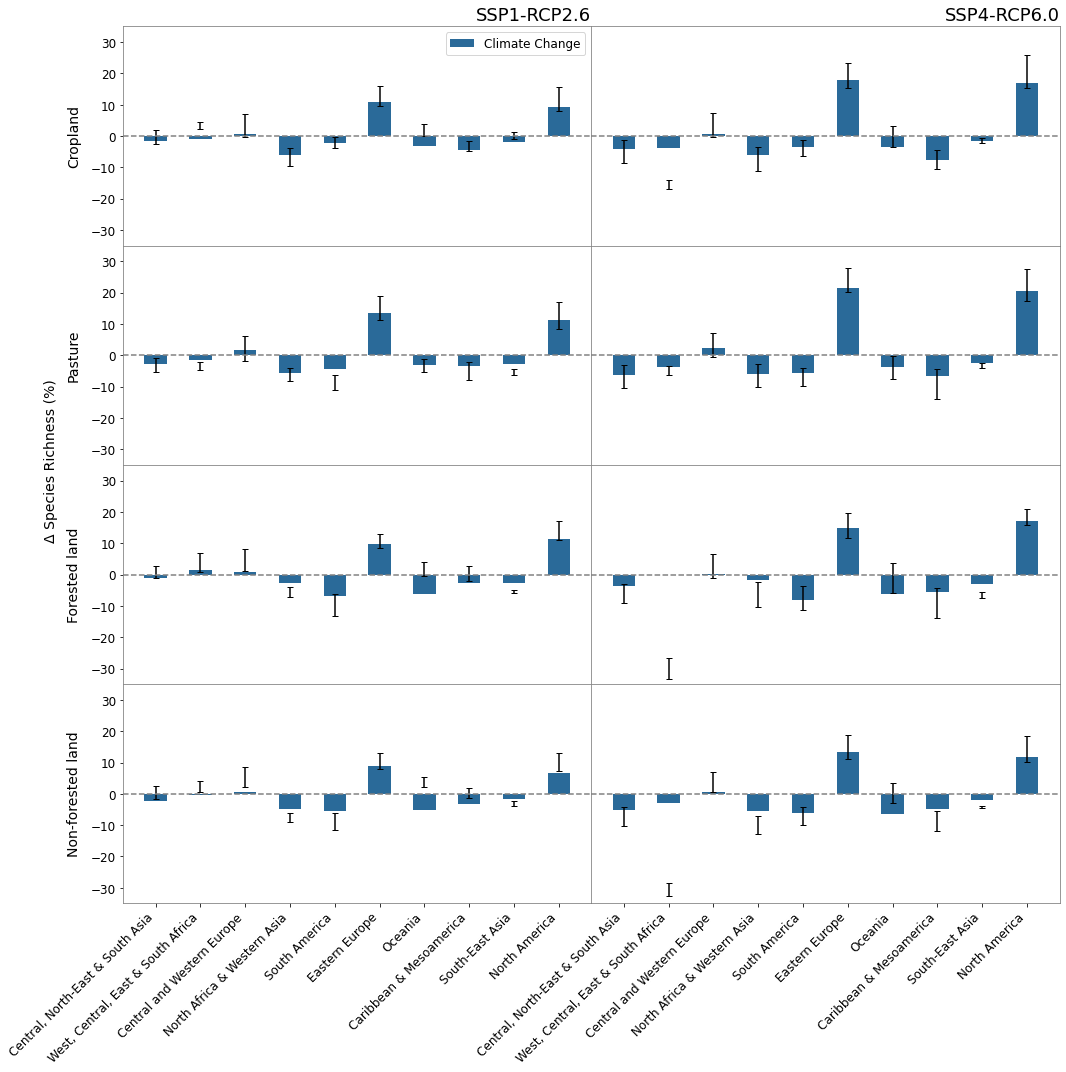

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib as mpl

# Define some parameters for the bar plots
width = 0.3  # the width of the bars
min_threshold = 1e-6
# Create the x-axis positions for the bars
x = np.arange(len(regionlist)) / 2
scenario_indices={"rcp26": 'SSP1-RCP2.6', "rcp60": 'SSP4-RCP6.0'}
habitat_indices={"forest": 'Forested land', "natural_land": 'Non-forested land',"cropland": 'Cropland',"pasture": 'Pasture'}


# Create the x-axis positions for the bars
x = np.arange(len(regionlist))  # Assuming regionlist is the list of all regions
def set_plot_param():
    """Set my own customized plotting parameters"""
    mpl.rc('axes', edgecolor='grey')
    mpl.rc('axes', labelcolor='black')
    mpl.rc('xtick', color='black')
    mpl.rc('xtick', labelsize=12)
    mpl.rc('ytick', color='black')
    mpl.rc('ytick', labelsize=12)
    mpl.rc('axes', titlesize=18)
    mpl.rc('axes', labelsize=12)
    mpl.rc('legend', fontsize='large')
    mpl.rc('text', color='black')

# Call the function to set the plot parameters
set_plot_param()
# Define figure and axes for the matrix of plots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))  # Adjust the size as needed

# Loop over each habitat and scenario to create each subplot
for i, habitat in enumerate(habitats):
    for j, scenario in enumerate(scenarios):
        ax = axes[i][j]  # This is the current axes object to plot on

        # Initialize lists for plotting
        rel_diff_newvalue_means = []
        rel_diff_sumbins = []
        std_dev_newvalue = []

        # Iterate over each region for the specific habitat and scenario
        for region in regionlist:
            oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
            oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
            sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
            oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

            # Calculate th
            newvalue_future = mean_over_all_sdms_gcms_fut[scenario][habitat]
            newvalue_hist = mean_over_all_sdms_gcms_hist[scenario][habitat]
            sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat]
            sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat]



            # Calculate the relative difference safely
            non_zero_mask = sumbin_future != 0
            newvalue_hist_filtered = newvalue_hist.where(newvalue_hist > min_threshold, np.nan)
            difference = xr.where(newvalue_hist != 0, (newvalue_future - newvalue_hist) / newvalue_hist_filtered * 100, 0)
            climate_change = difference.where((difference >= -100) & (difference <= 100))

            climate_change = climate_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            sumbin_hist_filtered = sumbin_hist.where(sumbin_hist > min_threshold, np.nan)
            difference = (sumbin_future - sumbin_hist_filtered) / sumbin_hist_filtered * 100
            climate_land_change = difference.where((difference >= -100) & (difference <= 100))

            climate_land_change = climate_land_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            luc = climate_land_change - climate_change

            rel_diff_newvalue_mean = climate_change.mean()
            rel_diff_sumbin = luc.mean()

            # Append the values to the list
            rel_diff_newvalue_means.append(rel_diff_newvalue_mean)
            rel_diff_sumbins.append(rel_diff_sumbin)


            means_for_std = []

            for sdm in sdms:
                for gcm in gcms:

                    sep_future = mean_newvalue_fut[scenario][habitat][sdm][gcm]
                    sep_hist = mean_newvalue_hist[scenario][habitat][sdm][gcm]
                    sep_hist_filtered = sep_hist.where(sep_hist > min_threshold, np.nan)
                    difference = xr.where(sep_hist != 0, (sep_future - sep_hist) / sep_hist_filtered * 100, 0)
                    relative_change = difference.where((difference >= -100) & (difference <= 100))
                    relative_change = relative_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)

                    # Calculate the mean for this SDM and GCM
                    mean_relative_change = np.nanmean(relative_change.values)
                    means_for_std.append(mean_relative_change)

            # Compute the standard deviation of these means
            std_dev_newvalue_region = np.nanstd(means_for_std)
            std_dev_newvalue.append(std_dev_newvalue_region)

        total_heights = np.array(rel_diff_newvalue_means) + np.array(rel_diff_sumbins)

        # Plotting the bars
        width = 0.5 # the width of the bars
        ax.bar(x , rel_diff_newvalue_means, width,  label='Climate Change', color="#2a6a99")
      

        # Adding error total_heights
        ax.errorbar(x,total_heights, yerr=std_dev_newvalue,  fmt='none', capsize=3, color='black')

        ax.set_ylim([-35, 35])
        ax.axhline(y=0, color='gray', linestyle='--')
        # If this is the last row, set the x-tick labels
        if i == len(habitats) - 1:
            ax.set_xticks(x)
            ax.set_xticklabels(regionlist, rotation=45, ha='right')
        else:
            ax.set_xticks([])  # No x-tick labels for other rows

        # If this is the first column, set the y-label

            
        if j == 1:
            ax.set_yticks([])


        # Set the title for the top row
        if i == 0:
            ax.set_title(f'{scenario_indices[scenario]}',loc='right')

        # Add the legend only for the first subplot or as per your preference
        if i == 0 and j == 0:
            ax.legend()

# Add the habitat labels on the right side of the plot matrix
for i, habitat in enumerate(habitats):
    axes[i, -1].text(-1.12, 0.5, habitat_indices[habitat], transform=axes[i, -1].transAxes, rotation=90, va='center', fontsize=14)
fig.text(0.05, 0.57, 'Δ Species Richness (%)', va='center', rotation='vertical', fontsize=14)

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)  # Adjust this value as needed

plt.show()

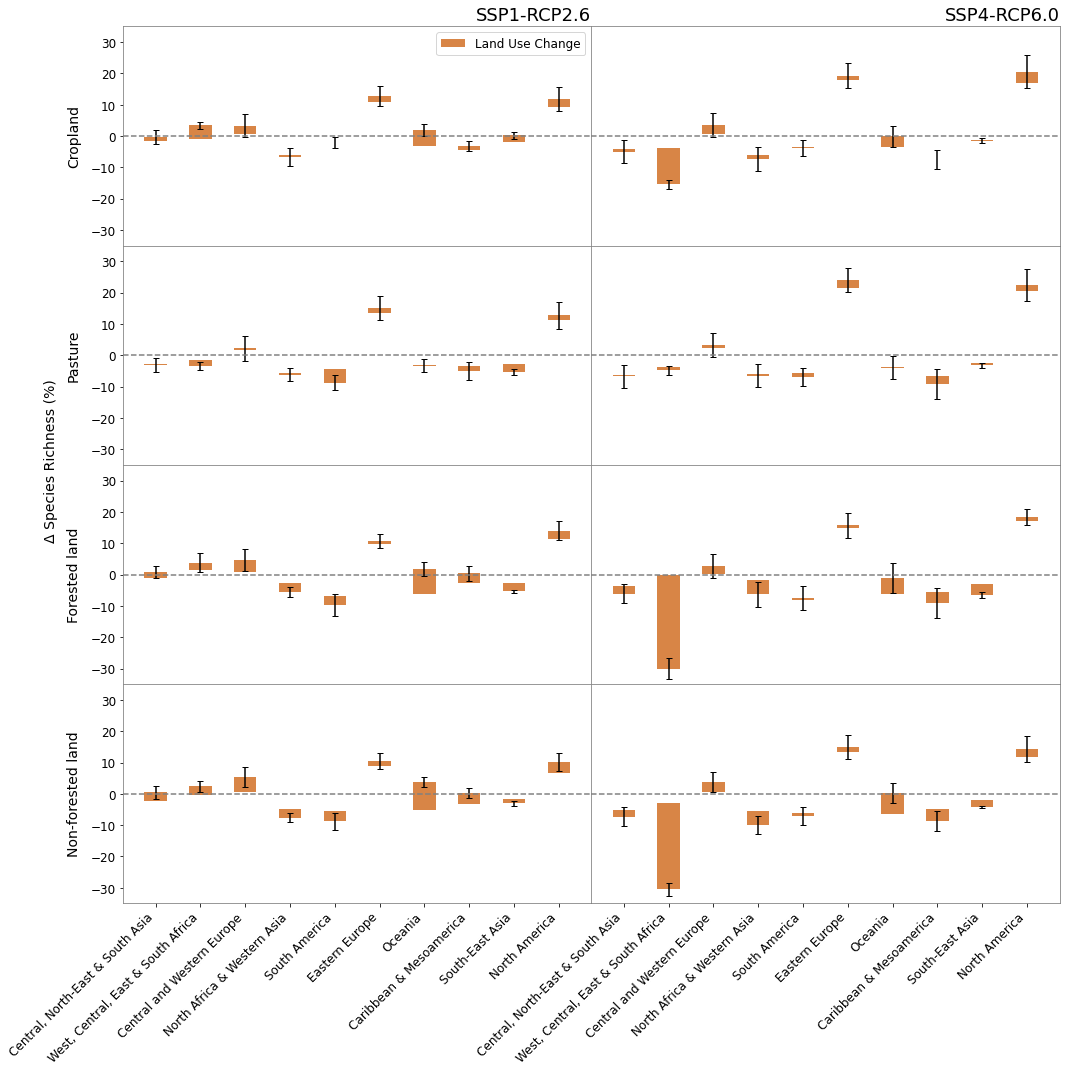

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib as mpl

# Define some parameters for the bar plots
width = 0.3  # the width of the bars
min_threshold = 1e-6
# Create the x-axis positions for the bars
x = np.arange(len(regionlist)) / 2
scenario_indices={"rcp26": 'SSP1-RCP2.6', "rcp60": 'SSP4-RCP6.0'}
habitat_indices={"forest": 'Forested land', "natural_land": 'Non-forested land',"cropland": 'Cropland',"pasture": 'Pasture'}


# Create the x-axis positions for the bars
x = np.arange(len(regionlist))  # Assuming regionlist is the list of all regions
def set_plot_param():
    """Set my own customized plotting parameters"""
    mpl.rc('axes', edgecolor='grey')
    mpl.rc('axes', labelcolor='black')
    mpl.rc('xtick', color='black')
    mpl.rc('xtick', labelsize=12)
    mpl.rc('ytick', color='black')
    mpl.rc('ytick', labelsize=12)
    mpl.rc('axes', titlesize=18)
    mpl.rc('axes', labelsize=12)
    mpl.rc('legend', fontsize='large')
    mpl.rc('text', color='black')

# Call the function to set the plot parameters
set_plot_param()
# Define figure and axes for the matrix of plots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))  # Adjust the size as needed

# Loop over each habitat and scenario to create each subplot
for i, habitat in enumerate(habitats):
    for j, scenario in enumerate(scenarios):
        ax = axes[i][j]  # This is the current axes object to plot on

        # Initialize lists for plotting
        rel_diff_newvalue_means = []
        rel_diff_sumbins = []
        std_dev_newvalue = []

        # Iterate over each region for the specific habitat and scenario
        for region in regionlist:
            oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
            oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
            sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
            oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

            # Calculate th
            newvalue_future = mean_over_all_sdms_gcms_fut[scenario][habitat]
            newvalue_hist = mean_over_all_sdms_gcms_hist[scenario][habitat]
            sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat]
            sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat]



            # Calculate the relative difference safely
            non_zero_mask = sumbin_future != 0
            newvalue_hist_filtered = newvalue_hist.where(newvalue_hist > min_threshold, np.nan)
            difference = xr.where(newvalue_hist != 0, (newvalue_future - newvalue_hist) / newvalue_hist_filtered * 100, 0)
            climate_change = difference.where((difference >= -100) & (difference <= 100))

            climate_change = climate_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            sumbin_hist_filtered = sumbin_hist.where(sumbin_hist > min_threshold, np.nan)
            difference = (sumbin_future - sumbin_hist_filtered) / sumbin_hist_filtered * 100
            climate_land_change = difference.where((difference >= -100) & (difference <= 100))

            climate_land_change = climate_land_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            luc = climate_land_change - climate_change

            rel_diff_newvalue_mean = climate_change.mean()
            rel_diff_sumbin = luc.mean()

            # Append the values to the list
            rel_diff_newvalue_means.append(rel_diff_newvalue_mean)
            rel_diff_sumbins.append(rel_diff_sumbin)


            means_for_std = []

            for sdm in sdms:
                for gcm in gcms:

                    sep_future = mean_newvalue_fut[scenario][habitat][sdm][gcm]
                    sep_hist = mean_newvalue_hist[scenario][habitat][sdm][gcm]
                    sep_hist_filtered = sep_hist.where(sep_hist > min_threshold, np.nan)
                    difference = xr.where(sep_hist != 0, (sep_future - sep_hist) / sep_hist_filtered * 100, 0)
                    relative_change = difference.where((difference >= -100) & (difference <= 100))
                    relative_change = relative_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)

                    # Calculate the mean for this SDM and GCM
                    mean_relative_change = np.nanmean(relative_change.values)
                    means_for_std.append(mean_relative_change)

            # Compute the standard deviation of these means
            std_dev_newvalue_region = np.nanstd(means_for_std)
            std_dev_newvalue.append(std_dev_newvalue_region)

        total_heights = np.array(rel_diff_newvalue_means) + np.array(rel_diff_sumbins)

        # Plotting the bars
        width = 0.5 # the width of the bars
        ax.bar(x , rel_diff_sumbins, width, rel_diff_newvalue_means,  label='Land Use Change', color="#d88546")
      

        # Adding error bars
        ax.errorbar(x,total_heights, yerr=std_dev_newvalue, fmt='none', capsize=3, color='black')

        ax.set_ylim([-35, 35])
        ax.axhline(y=0, color='gray', linestyle='--')
        # If this is the last row, set the x-tick labels
        if i == len(habitats) - 1:
            ax.set_xticks(x)
            ax.set_xticklabels(regionlist, rotation=45, ha='right')
        else:
            ax.set_xticks([])  # No x-tick labels for other rows

        # If this is the first column, set the y-label

            
        if j == 1:
            ax.set_yticks([])


        # Set the title for the top row
        if i == 0:
            ax.set_title(f'{scenario_indices[scenario]}',loc='right')

        # Add the legend only for the first subplot or as per your preference
        if i == 0 and j == 0:
            ax.legend()

# Add the habitat labels on the right side of the plot matrix
for i, habitat in enumerate(habitats):
    axes[i, -1].text(-1.12, 0.5, habitat_indices[habitat], transform=axes[i, -1].transAxes, rotation=90, va='center', fontsize=14)
fig.text(0.05, 0.57, 'Δ Species Richness (%)', va='center', rotation='vertical', fontsize=14)

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)  # Adjust this value as needed

plt.show()

In [12]:
df.to_csv("/storage/homefs/ch21o450/scripts/climate_Hari_etal_inprep/functions/figures/main_figures/output_fig3.csv", index=True)

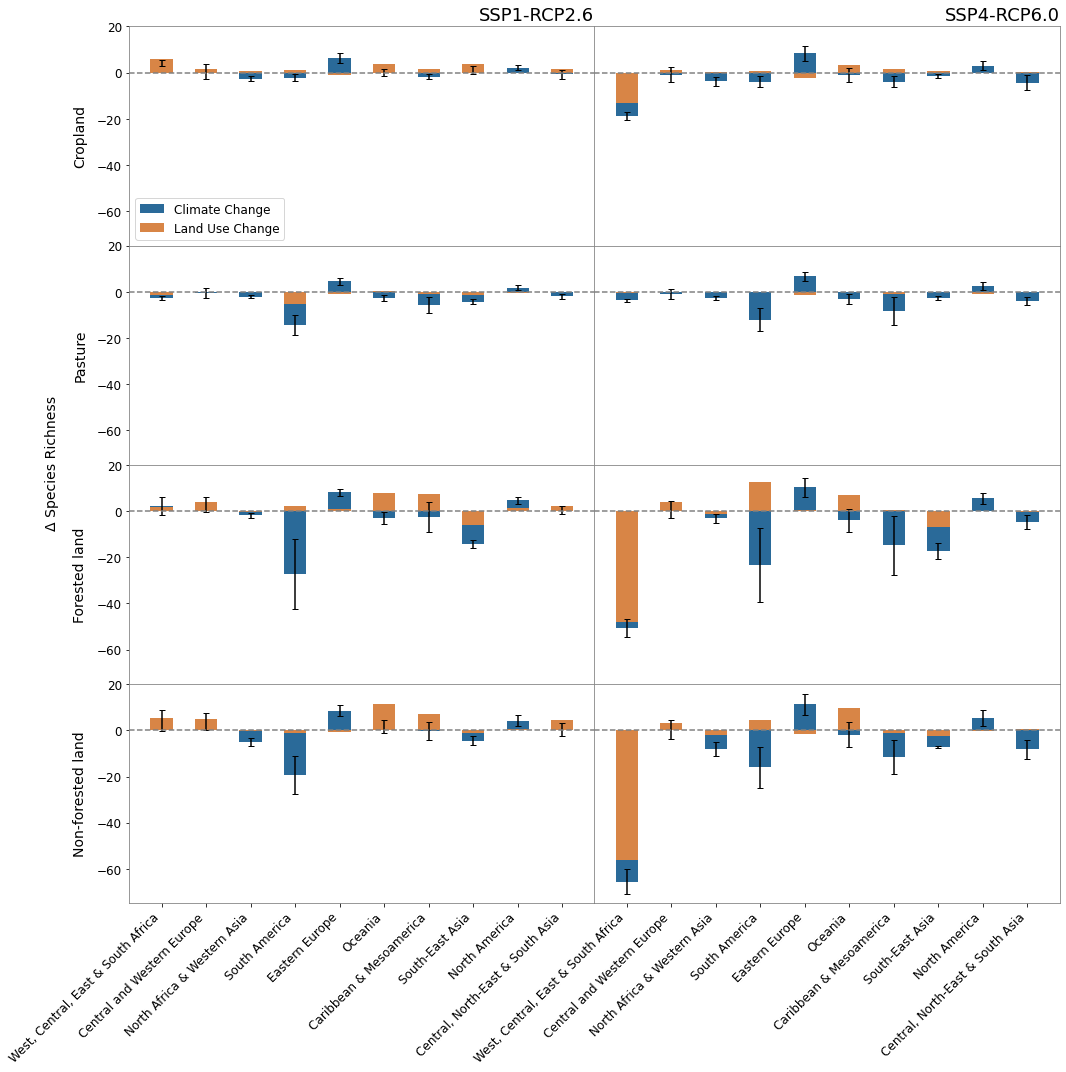

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib as mpl

# Define some parameters for the bar plots
width = 0.3  # the width of the bars
min_threshold = 1e-6
# Create the x-axis positions for the bars
x = np.arange(len(regionlist)) / 2
scenario_indices={"rcp26": 'SSP1-RCP2.6', "rcp60": 'SSP4-RCP6.0'}
habitat_indices={"forest": 'Forested land', "natural_land": 'Non-forested land',"cropland": 'Cropland',"pasture": 'Pasture'}


# Create the x-axis positions for the bars
x = np.arange(len(regionlist))  # Assuming regionlist is the list of all regions
def set_plot_param():
    """Set my own customized plotting parameters"""
    mpl.rc('axes', edgecolor='grey')
    mpl.rc('axes', labelcolor='black')
    mpl.rc('xtick', color='black')
    mpl.rc('xtick', labelsize=12)
    mpl.rc('ytick', color='black')
    mpl.rc('ytick', labelsize=12)
    mpl.rc('axes', titlesize=18)
    mpl.rc('axes', labelsize=12)
    mpl.rc('legend', fontsize='large')
    mpl.rc('text', color='black')

# Call the function to set the plot parameters
set_plot_param()
# Define figure and axes for the matrix of plots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))  # Adjust the size as needed

# Loop over each habitat and scenario to create each subplot
for i, habitat in enumerate(habitats):
    for j, scenario in enumerate(scenarios):
        ax = axes[i][j]  # This is the current axes object to plot on

        # Initialize lists for plotting
        rel_diff_newvalue_means = []
        rel_diff_sumbins = []
        std_dev_newvalue = []

        # Iterate over each region for the specific habitat and scenario
        for region in regionlist:
            oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
            oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
            sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
            oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

            # Calculate th
            newvalue_future = mean_over_all_sdms_gcms_fut[scenario][habitat]
            newvalue_hist = mean_over_all_sdms_gcms_hist[scenario][habitat]
            sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat]
            sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat]



            # Calculate the relative difference safely
            non_zero_mask = sumbin_future != 0

            difference = (newvalue_future - newvalue_hist)


            climate_change = difference.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            difference = (sumbin_future - sumbin_hist) 


            climate_land_change = difference.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            luc = climate_land_change - climate_change

            rel_diff_newvalue_mean = climate_change.mean()
            rel_diff_sumbin = luc.mean()

            # Append the values to the list
            rel_diff_newvalue_means.append(rel_diff_newvalue_mean)
            rel_diff_sumbins.append(rel_diff_sumbin)


            means_for_std = []

            for sdm in sdms:
                for gcm in gcms:

                    sep_future = mean_newvalue_fut[scenario][habitat][sdm][gcm]
                    sep_hist = mean_newvalue_hist[scenario][habitat][sdm][gcm]
                    difference = sep_future - sep_hist
                    # Calculate the mean for this SDM and GCM
                    relative_change = difference.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)
                    mean_relative_change = np.nanmean(relative_change.values)
                    means_for_std.append(mean_relative_change)

            # Compute the standard deviation of these means
            std_dev_newvalue_region = np.nanstd(means_for_std)
            std_dev_newvalue.append(std_dev_newvalue_region)

        total_heights = np.array(rel_diff_newvalue_means) + np.array(rel_diff_sumbins)
        ax.set_ylim([-75, 20])
        # Plotting the bars
        width = 0.5 # the width of the bars
        ax.bar(x , rel_diff_newvalue_means, width, bottom=rel_diff_sumbins, label='Climate Change', color="#2a6a99")
        ax.bar(x , rel_diff_sumbins, width, label='Land Use Change', color="#d88546")

        # Adding error bars
        ax.errorbar(x, total_heights, yerr=std_dev_newvalue, fmt='none', capsize=3, color='black')

        #ax.set_ylim([-35, 35])
        ax.axhline(y=0, color='gray', linestyle='--')
        # If this is the last row, set the x-tick labels
        if i == len(habitats) - 1:
            ax.set_xticks(x)
            ax.set_xticklabels(regionlist, rotation=45, ha='right')
        else:
            ax.set_xticks([])  # No x-tick labels for other rows

        # If this is the first column, set the y-label

            
        if j == 1:
            ax.set_yticks([])


        # Set the title for the top row
        if i == 0:
            ax.set_title(f'{scenario_indices[scenario]}',loc='right')

        # Add the legend only for the first subplot or as per your preference
        if i == 0 and j == 0:
            ax.legend()

# Add the habitat labels on the right side of the plot matrix
for i, habitat in enumerate(habitats):
    axes[i, -1].text(-1.12, 0.5, habitat_indices[habitat], transform=axes[i, -1].transAxes, rotation=90, va='center', fontsize=14)
fig.text(0.05, 0.57, 'Δ Species Richness ', va='center', rotation='vertical', fontsize=14)

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)  # Adjust this value as needed

# Show the plot
plt.show()

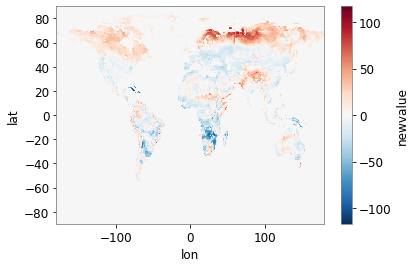

In [28]:
difference.plot()

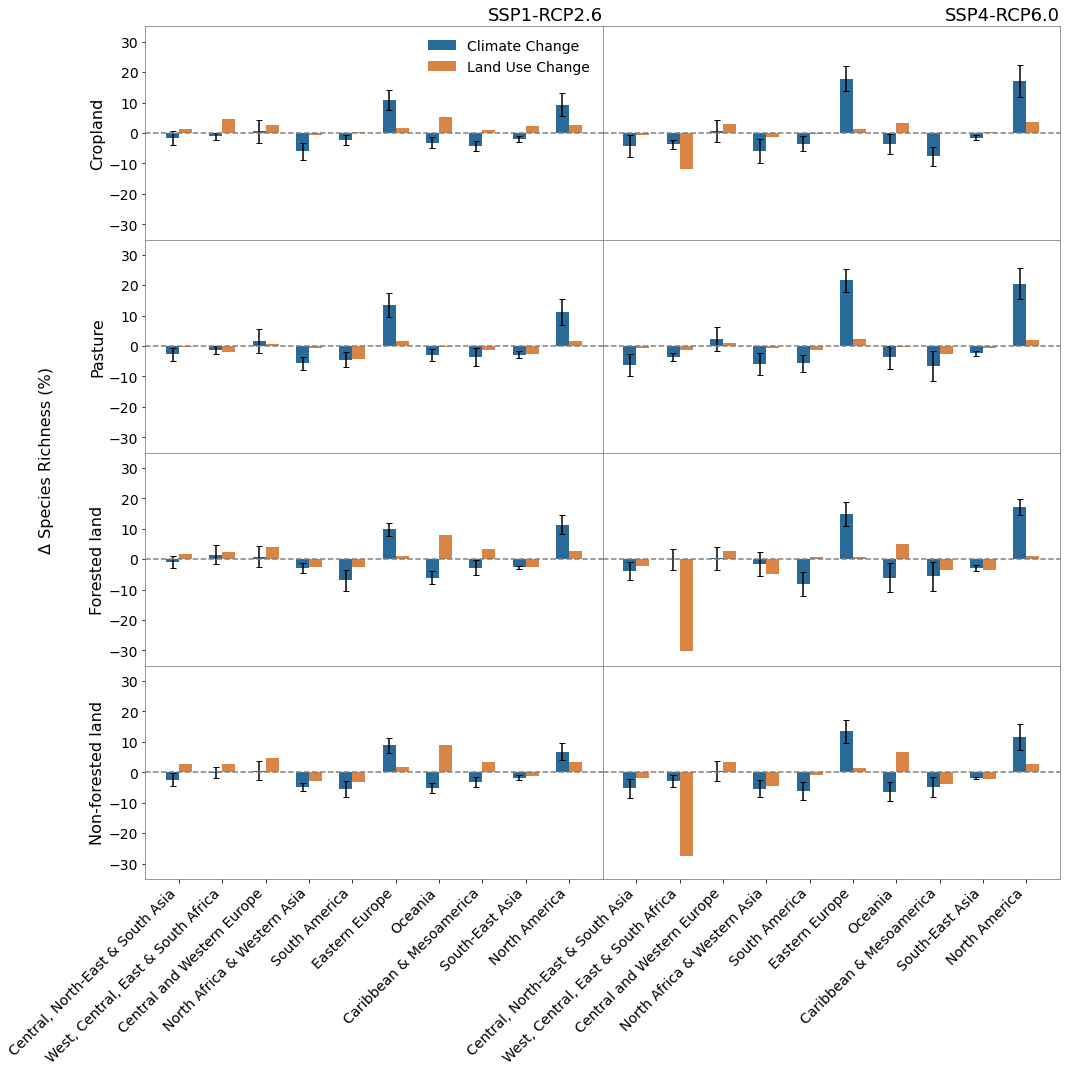

In [63]:

output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/habitats/"

# Assuming you have already read the shapefile and created the 'new_region' column
# If not, include the relevant code for reading and creating the 'new_region' column from your previous messages

regionlist = ['Central, North-East & South Asia','West, Central, East & South Africa', 'Central and Western Europe','North Africa & Western Asia', 'South America','Eastern Europe', 'Oceania', 'Caribbean & Mesoamerica', 'South-East Asia', 'North America'             ]
# Create an empty dictionary to store mean species richness for each region and each scenario
mean_species_richness_dict = {'sumbin_future': {}, 'sumbin_hist': {}, 'diff_sumbin': {}}
taxas = ["Mammals"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenario = ["rcp26", "rcp60"] 
habitats=["cropland","pasture","forest","natural_land"]
scenarios = ["rcp26", "rcp60"]
historical_time = 1146
future_time = 65
time = '65'
time_ind=65


mean_newvalue_hist= {}
mean_newvalue_fut = {}
mean_sumbin_hist = {}
mean_sumbin_fut = {}
    
mean_over_sdms_gcms_hist = {}
mean_over_sdms_gcms_fut = {}
mean_over_sdms_gcms_sumbin_hist = {}
mean_over_sdms_gcms_sumbin_fut = {}

mean_over_all_sdms_gcms_hist = {}
mean_over_all_sdms_gcms_fut = {}
mean_over_all_sdms_gcms_sumbin_hist = {}
mean_over_all_sdms_gcms_sumbin_fut = {}


for scenario in scenarios:

    mean_over_sdms_gcms_hist[scenario] = {}
    mean_over_sdms_gcms_fut[scenario] = {}
    mean_over_sdms_gcms_sumbin_hist[scenario] = {}
    mean_over_sdms_gcms_sumbin_fut[scenario] = {}
    
    mean_over_all_sdms_gcms_hist[scenario] = {}
    mean_over_all_sdms_gcms_fut[scenario] = {}
    mean_over_all_sdms_gcms_sumbin_hist[scenario] = {}
    mean_over_all_sdms_gcms_sumbin_fut[scenario] = {}
    
    mean_newvalue_hist[scenario] = {}
    mean_newvalue_fut[scenario] = {}
    mean_sumbin_hist[scenario] = {}
    mean_sumbin_fut[scenario] = {}
    
    dataarrays_sdms_newvalue_hist = []
    dataarrays_sdms_newvalue_fut = []
    dataarrays_sdms_sumbin_hist = []
    dataarrays_sdms_sumbin_fut = []

    for habitat in habitats:

        # Initialize taxa-level lists
        dataarrays_sdms_newvalue_hist = []
        dataarrays_sdms_newvalue_fut = []
        dataarrays_sdms_sumbin_hist = []
        dataarrays_sdms_sumbin_fut = []
        
        mean_over_sdms_gcms_hist[scenario][habitat] = {}
        mean_over_sdms_gcms_fut[scenario][habitat] = {}
        mean_over_sdms_gcms_sumbin_hist[scenario][habitat] = {}
        mean_over_sdms_gcms_sumbin_fut[scenario][habitat] = {}

        mean_over_all_sdms_gcms_hist[scenario][habitat] = {}
        mean_over_all_sdms_gcms_fut[scenario][habitat] = {}
        mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat] = {}
        mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat] = {}

        mean_newvalue_hist[scenario][habitat] = {}
        mean_newvalue_fut[scenario][habitat] = {}
        mean_sumbin_hist[scenario][habitat] = {}
        mean_sumbin_fut[scenario][habitat] = {}

        for sdm in sdms:

            mean_newvalue_hist[scenario][habitat][sdm] = {}
            mean_newvalue_fut[scenario][habitat][sdm] = {}
            mean_sumbin_hist[scenario][habitat][sdm] = {}
            mean_sumbin_fut[scenario][habitat][sdm] = {}

            dataarrays_newvalue_hist = []
            dataarrays_newvalue_fut = []
            dataarrays_sumbin_hist = []
            dataarrays_sumbin_fut = []


            for gcm in gcms:
                mean_newvalue_hist[scenario][habitat][sdm][gcm] = {}
                mean_newvalue_fut[scenario][habitat][sdm][gcm] = {}
                mean_sumbin_hist[scenario][habitat][sdm][gcm] = {}
                mean_sumbin_fut[scenario][habitat][sdm][gcm] = {}

                sum_newvalue_hist = None
                sum_newvalue_future = None
                sum_sumbin_hist = None
                sum_sumbin_future = None

                # Load pickle files
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}']_dispersal4.pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}']_dispersal4.pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}']_dispersal4.pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}']_dispersal4.pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_taxa = pd.read_pickle(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_taxa = pd.read_pickle(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_taxa = pd.read_pickle(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_taxa = pd.read_pickle(f)
                    
                weights_newvalue = np.cos(np.deg2rad(newvalue_hist_taxa.lat))
                weights_newvalue.name = "weights"

                    
                # Assign the summed values to your dictionary
                mean_newvalue_hist[scenario][habitat][sdm][gcm] = newvalue_hist_taxa
                mean_newvalue_fut[scenario][habitat][sdm][gcm] = newvalue_future_taxa
                mean_sumbin_hist[scenario][habitat][sdm][gcm] = sum_bin_hist_taxa
                mean_sumbin_fut[scenario][habitat][sdm][gcm] = sum_bin_future_taxa

                dataarrays_newvalue_hist.append(mean_newvalue_hist[scenario][habitat][sdm][gcm])
                dataarrays_newvalue_fut.append(mean_newvalue_fut[scenario][habitat][sdm][gcm])
                dataarrays_sumbin_hist.append(mean_sumbin_hist[scenario][habitat][sdm][gcm])
                dataarrays_sumbin_fut.append(mean_sumbin_fut[scenario][habitat][sdm][gcm])
                

            # Concatenate and calculate the mean over the new dimension
            mean_over_sdms_gcms_hist[scenario][habitat][sdm] = xr.concat(dataarrays_newvalue_hist, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')
            mean_over_sdms_gcms_fut[scenario][habitat][sdm] = xr.concat(dataarrays_newvalue_fut, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')
            mean_over_sdms_gcms_sumbin_hist[scenario][habitat][sdm] = xr.concat(dataarrays_sumbin_hist, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')
            mean_over_sdms_gcms_sumbin_fut[scenario][habitat][sdm] = xr.concat(dataarrays_sumbin_fut, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')

                   # Append the mean DataArrays across GCMs to the SDM lists
            dataarrays_sdms_newvalue_hist.append(mean_over_sdms_gcms_hist[scenario][habitat][sdm])
            dataarrays_sdms_newvalue_fut.append(mean_over_sdms_gcms_fut[scenario][habitat][sdm])
            dataarrays_sdms_sumbin_hist.append(mean_over_sdms_gcms_sumbin_hist[scenario][habitat][sdm])
            dataarrays_sdms_sumbin_fut.append(mean_over_sdms_gcms_sumbin_fut[scenario][habitat][sdm])

        # Concatenate and calculate the mean over SDMs
        mean_over_all_sdms_gcms_hist[scenario][habitat] = xr.concat(dataarrays_sdms_newvalue_hist, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
        mean_over_all_sdms_gcms_fut[scenario][habitat] = xr.concat(dataarrays_sdms_newvalue_fut, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
        mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat] = xr.concat(dataarrays_sdms_sumbin_hist, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
        mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat] = xr.concat(dataarrays_sdms_sumbin_fut, dim='sdm').weighted(weights_newvalue).mean(dim='sdm') 
        
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib as mpl

# Define some parameters for the bar plots
width = 0.5 # the width of the bars
min_threshold = 1e-6
# Create the x-axis positions for the bars
x = np.arange(len(regionlist)) / 2
scenario_indices={"rcp26": 'SSP1-RCP2.6', "rcp60": 'SSP4-RCP6.0'}
habitat_indices={"forest": 'Forested land', "natural_land": 'Non-forested land',"cropland": 'Cropland',"pasture": 'Pasture'}


# Create the x-axis positions for the bars
x = np.arange(len(regionlist))  # Assuming regionlist is the list of all regions




# Define figure and axes for the matrix of plots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))  # Adjust the size as needed

# Loop over each habitat and scenario to create each subplot
for i, habitat in enumerate(habitats):
    for j, scenario in enumerate(scenarios):
        ax = axes[i][j]  # This is the current axes object to plot on

        # Initialize lists for plotting
        rel_diff_newvalue_means = []
        rel_diff_sumbins = []
        std_dev_newvalue = []

        # Iterate over each region for the specific habitat and scenario
        for region in regionlist:
            oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
            oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
            sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
            oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

            # Calculate th
            newvalue_future = mean_over_all_sdms_gcms_fut[scenario][habitat]
            newvalue_hist = mean_over_all_sdms_gcms_hist[scenario][habitat]
            sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat]
            sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat]



            # Calculate the relative difference safely
            non_zero_mask = sumbin_future != 0
            newvalue_hist_filtered = newvalue_hist.where(newvalue_hist > min_threshold, np.nan)
            difference = xr.where(newvalue_hist != 0, (newvalue_future - newvalue_hist) / newvalue_hist_filtered * 100, 0)
            climate_change = difference.where((difference >= -100) & (difference <= 100))

            climate_change = climate_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            sumbin_hist_filtered = sumbin_hist.where(sumbin_hist > min_threshold, np.nan)
            difference = (sumbin_future - sumbin_hist_filtered) / sumbin_hist_filtered * 100
            climate_land_change = difference.where((difference >= -100) & (difference <= 100))

            climate_land_change = climate_land_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            luc = climate_land_change - climate_change

            rel_diff_newvalue_mean = climate_change.mean()
            rel_diff_sumbin = luc.mean()

            # Append the values to the list
            rel_diff_newvalue_means.append(rel_diff_newvalue_mean)
            rel_diff_sumbins.append(rel_diff_sumbin)


            means_for_std = []

            for sdm in sdms:
                for gcm in gcms:

                    sep_future = mean_newvalue_fut[scenario][habitat][sdm][gcm]
                    sep_hist = mean_newvalue_hist[scenario][habitat][sdm][gcm]
                    sep_hist_filtered = sep_hist.where(sep_hist > min_threshold, np.nan)
                    difference = xr.where(sep_hist != 0, (sep_future - sep_hist) / sep_hist_filtered * 100, 0)
                    relative_change = difference.where((difference >= -100) & (difference <= 100))
                    relative_change = relative_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)

                    # Calculate the mean for this SDM and GCM
                    mean_relative_change = np.nanmean(relative_change.values)
                    means_for_std.append(mean_relative_change)

            # Compute the standard deviation of these means
            std_dev_newvalue_region = np.nanstd(means_for_std)
            std_dev_newvalue.append(std_dev_newvalue_region)

        total_heights = np.array(rel_diff_newvalue_means) + np.array(rel_diff_sumbins)

        # Plotting the bars
        width = 0.3 # the width of the bars
        offset = width / 2  # Half the width of the bar
        x1 = x - offset  # Positions for the first set of bars
        x2 = x + offset  # Positions for the second set of bars

        # Plotting the bars with alpha for transparency
        ax.bar(x1, rel_diff_newvalue_means, width, label='Climate Change', color="#2a6a99")
        ax.bar(x2, rel_diff_sumbins, width, label='Land Use Change', color="#d88546")
        

        

        # Adding error bars
        ax.errorbar(x1,rel_diff_newvalue_means, yerr=std_dev_newvalue, fmt='none', capsize=3, color='black')

        ax.set_ylim([-35, 35])
        ax.axhline(y=0, color='gray', linestyle='--')
        # If this is the last row, set the x-tick labels
        if i == len(habitats) - 1:
            ax.set_xticks(x)
            ax.set_xticklabels(regionlist, rotation=45, ha='right', fontsize=14)
        else:
            ax.set_xticks([])  # No x-tick labels for other rows

        # If this is the first column, set the y-label

            
        if j == 1:
            ax.set_yticks([])


        # Set the title for the top row
        if i == 0:
            ax.set_title(f'{scenario_indices[scenario]}',loc='right')

        # Add the legend only for the first subplot or as per your preference
        if i == 0 and j == 0:
            ax.legend(frameon=False, fontsize=14)

# Add the habitat labels on the right side of the plot matrix
for i, habitat in enumerate(habitats):
    axes[i, -1].text(-1.12, 0.5, habitat_indices[habitat], transform=axes[i, -1].transAxes, rotation=90, va='center', fontsize=16)

fig.text(0.045, 0.57, 'Δ Species Richness (%)', va='center', rotation='vertical',fontsize=16)
set_plot_param()
# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)  # Adjust this value as needed
plt.savefig("/storage/homefs/ch21o450/scripts/climate_Hari_etal_inprep/functions/figures/main_figures/S_Mammals")
# Show the plot
plt.show()

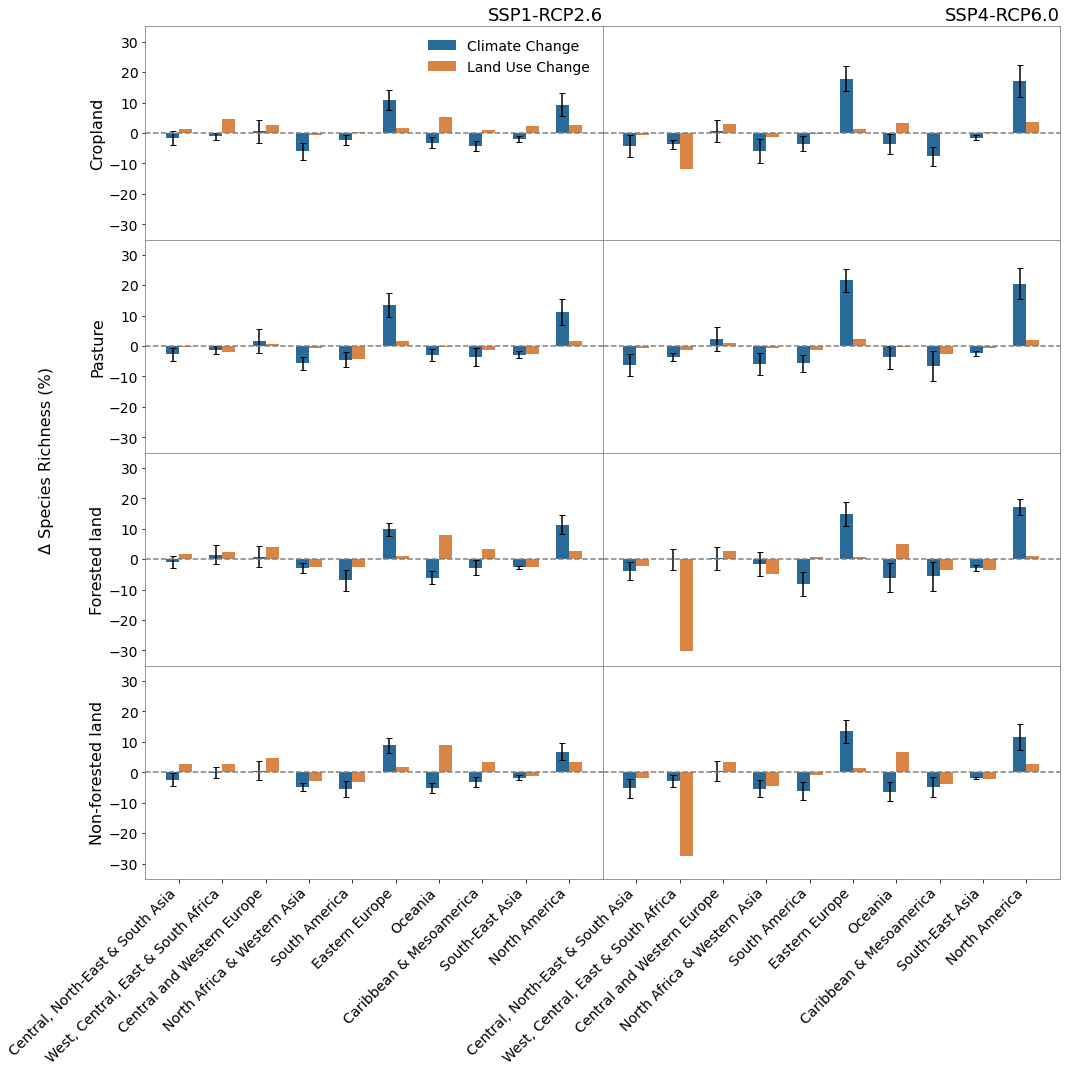

In [61]:

output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/habitats/"

# Assuming you have already read the shapefile and created the 'new_region' column
# If not, include the relevant code for reading and creating the 'new_region' column from your previous messages

regionlist = ['Central, North-East & South Asia','West, Central, East & South Africa', 'Central and Western Europe','North Africa & Western Asia', 'South America','Eastern Europe', 'Oceania', 'Caribbean & Mesoamerica', 'South-East Asia', 'North America'             ]
# Create an empty dictionary to store mean species richness for each region and each scenario
mean_species_richness_dict = {'sumbin_future': {}, 'sumbin_hist': {}, 'diff_sumbin': {}}
taxas = ["Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenario = ["rcp26", "rcp60"] 
habitats=["cropland","pasture","forest","natural_land"]
scenarios = ["rcp26", "rcp60"]
historical_time = 1146
future_time = 65
time = '65'
time_ind=65


mean_newvalue_hist= {}
mean_newvalue_fut = {}
mean_sumbin_hist = {}
mean_sumbin_fut = {}
    
mean_over_sdms_gcms_hist = {}
mean_over_sdms_gcms_fut = {}
mean_over_sdms_gcms_sumbin_hist = {}
mean_over_sdms_gcms_sumbin_fut = {}

mean_over_all_sdms_gcms_hist = {}
mean_over_all_sdms_gcms_fut = {}
mean_over_all_sdms_gcms_sumbin_hist = {}
mean_over_all_sdms_gcms_sumbin_fut = {}


for scenario in scenarios:

    mean_over_sdms_gcms_hist[scenario] = {}
    mean_over_sdms_gcms_fut[scenario] = {}
    mean_over_sdms_gcms_sumbin_hist[scenario] = {}
    mean_over_sdms_gcms_sumbin_fut[scenario] = {}
    
    mean_over_all_sdms_gcms_hist[scenario] = {}
    mean_over_all_sdms_gcms_fut[scenario] = {}
    mean_over_all_sdms_gcms_sumbin_hist[scenario] = {}
    mean_over_all_sdms_gcms_sumbin_fut[scenario] = {}
    
    mean_newvalue_hist[scenario] = {}
    mean_newvalue_fut[scenario] = {}
    mean_sumbin_hist[scenario] = {}
    mean_sumbin_fut[scenario] = {}
    
    dataarrays_sdms_newvalue_hist = []
    dataarrays_sdms_newvalue_fut = []
    dataarrays_sdms_sumbin_hist = []
    dataarrays_sdms_sumbin_fut = []

    for habitat in habitats:

        # Initialize taxa-level lists
        dataarrays_sdms_newvalue_hist = []
        dataarrays_sdms_newvalue_fut = []
        dataarrays_sdms_sumbin_hist = []
        dataarrays_sdms_sumbin_fut = []
        
        mean_over_sdms_gcms_hist[scenario][habitat] = {}
        mean_over_sdms_gcms_fut[scenario][habitat] = {}
        mean_over_sdms_gcms_sumbin_hist[scenario][habitat] = {}
        mean_over_sdms_gcms_sumbin_fut[scenario][habitat] = {}

        mean_over_all_sdms_gcms_hist[scenario][habitat] = {}
        mean_over_all_sdms_gcms_fut[scenario][habitat] = {}
        mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat] = {}
        mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat] = {}

        mean_newvalue_hist[scenario][habitat] = {}
        mean_newvalue_fut[scenario][habitat] = {}
        mean_sumbin_hist[scenario][habitat] = {}
        mean_sumbin_fut[scenario][habitat] = {}

        for sdm in sdms:

            mean_newvalue_hist[scenario][habitat][sdm] = {}
            mean_newvalue_fut[scenario][habitat][sdm] = {}
            mean_sumbin_hist[scenario][habitat][sdm] = {}
            mean_sumbin_fut[scenario][habitat][sdm] = {}

            dataarrays_newvalue_hist = []
            dataarrays_newvalue_fut = []
            dataarrays_sumbin_hist = []
            dataarrays_sumbin_fut = []


            for gcm in gcms:
                mean_newvalue_hist[scenario][habitat][sdm][gcm] = {}
                mean_newvalue_fut[scenario][habitat][sdm][gcm] = {}
                mean_sumbin_hist[scenario][habitat][sdm][gcm] = {}
                mean_sumbin_fut[scenario][habitat][sdm][gcm] = {}

                sum_newvalue_hist = None
                sum_newvalue_future = None
                sum_sumbin_hist = None
                sum_sumbin_future = None

                # Load pickle files
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}']_dispersal4.pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}']_dispersal4.pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}']_dispersal4.pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}']_dispersal4.pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_taxa = pd.read_pickle(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_taxa = pd.read_pickle(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_taxa = pd.read_pickle(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_taxa = pd.read_pickle(f)
                    
                weights_newvalue = np.cos(np.deg2rad(newvalue_hist_taxa.lat))
                weights_newvalue.name = "weights"

                    
                # Assign the summed values to your dictionary
                mean_newvalue_hist[scenario][habitat][sdm][gcm] = newvalue_hist_taxa
                mean_newvalue_fut[scenario][habitat][sdm][gcm] = newvalue_future_taxa
                mean_sumbin_hist[scenario][habitat][sdm][gcm] = sum_bin_hist_taxa
                mean_sumbin_fut[scenario][habitat][sdm][gcm] = sum_bin_future_taxa

                dataarrays_newvalue_hist.append(mean_newvalue_hist[scenario][habitat][sdm][gcm])
                dataarrays_newvalue_fut.append(mean_newvalue_fut[scenario][habitat][sdm][gcm])
                dataarrays_sumbin_hist.append(mean_sumbin_hist[scenario][habitat][sdm][gcm])
                dataarrays_sumbin_fut.append(mean_sumbin_fut[scenario][habitat][sdm][gcm])
                

            # Concatenate and calculate the mean over the new dimension
            mean_over_sdms_gcms_hist[scenario][habitat][sdm] = xr.concat(dataarrays_newvalue_hist, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')
            mean_over_sdms_gcms_fut[scenario][habitat][sdm] = xr.concat(dataarrays_newvalue_fut, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')
            mean_over_sdms_gcms_sumbin_hist[scenario][habitat][sdm] = xr.concat(dataarrays_sumbin_hist, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')
            mean_over_sdms_gcms_sumbin_fut[scenario][habitat][sdm] = xr.concat(dataarrays_sumbin_fut, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')

                   # Append the mean DataArrays across GCMs to the SDM lists
            dataarrays_sdms_newvalue_hist.append(mean_over_sdms_gcms_hist[scenario][habitat][sdm])
            dataarrays_sdms_newvalue_fut.append(mean_over_sdms_gcms_fut[scenario][habitat][sdm])
            dataarrays_sdms_sumbin_hist.append(mean_over_sdms_gcms_sumbin_hist[scenario][habitat][sdm])
            dataarrays_sdms_sumbin_fut.append(mean_over_sdms_gcms_sumbin_fut[scenario][habitat][sdm])

        # Concatenate and calculate the mean over SDMs
        mean_over_all_sdms_gcms_hist[scenario][habitat] = xr.concat(dataarrays_sdms_newvalue_hist, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
        mean_over_all_sdms_gcms_fut[scenario][habitat] = xr.concat(dataarrays_sdms_newvalue_fut, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
        mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat] = xr.concat(dataarrays_sdms_sumbin_hist, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
        mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat] = xr.concat(dataarrays_sdms_sumbin_fut, dim='sdm').weighted(weights_newvalue).mean(dim='sdm') 
        
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib as mpl

# Define some parameters for the bar plots
width = 0.5 # the width of the bars
min_threshold = 1e-6
# Create the x-axis positions for the bars
x = np.arange(len(regionlist)) / 2
scenario_indices={"rcp26": 'SSP1-RCP2.6', "rcp60": 'SSP4-RCP6.0'}
habitat_indices={"forest": 'Forested land', "natural_land": 'Non-forested land',"cropland": 'Cropland',"pasture": 'Pasture'}


# Create the x-axis positions for the bars
x = np.arange(len(regionlist))  # Assuming regionlist is the list of all regions




# Define figure and axes for the matrix of plots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))  # Adjust the size as needed

# Loop over each habitat and scenario to create each subplot
for i, habitat in enumerate(habitats):
    for j, scenario in enumerate(scenarios):
        ax = axes[i][j]  # This is the current axes object to plot on

        # Initialize lists for plotting
        rel_diff_newvalue_means = []
        rel_diff_sumbins = []
        std_dev_newvalue = []

        # Iterate over each region for the specific habitat and scenario
        for region in regionlist:
            oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
            oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
            sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
            oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

            # Calculate th
            newvalue_future = mean_over_all_sdms_gcms_fut[scenario][habitat]
            newvalue_hist = mean_over_all_sdms_gcms_hist[scenario][habitat]
            sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat]
            sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat]



            # Calculate the relative difference safely
            non_zero_mask = sumbin_future != 0
            newvalue_hist_filtered = newvalue_hist.where(newvalue_hist > min_threshold, np.nan)
            difference = xr.where(newvalue_hist != 0, (newvalue_future - newvalue_hist) / newvalue_hist_filtered * 100, 0)
            climate_change = difference.where((difference >= -100) & (difference <= 100))

            climate_change = climate_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            sumbin_hist_filtered = sumbin_hist.where(sumbin_hist > min_threshold, np.nan)
            difference = (sumbin_future - sumbin_hist_filtered) / sumbin_hist_filtered * 100
            climate_land_change = difference.where((difference >= -100) & (difference <= 100))

            climate_land_change = climate_land_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            luc = climate_land_change - climate_change

            rel_diff_newvalue_mean = climate_change.mean()
            rel_diff_sumbin = luc.mean()

            # Append the values to the list
            rel_diff_newvalue_means.append(rel_diff_newvalue_mean)
            rel_diff_sumbins.append(rel_diff_sumbin)


            means_for_std = []

            for sdm in sdms:
                for gcm in gcms:

                    sep_future = mean_newvalue_fut[scenario][habitat][sdm][gcm]
                    sep_hist = mean_newvalue_hist[scenario][habitat][sdm][gcm]
                    sep_hist_filtered = sep_hist.where(sep_hist > min_threshold, np.nan)
                    difference = xr.where(sep_hist != 0, (sep_future - sep_hist) / sep_hist_filtered * 100, 0)
                    relative_change = difference.where((difference >= -100) & (difference <= 100))
                    relative_change = relative_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)

                    # Calculate the mean for this SDM and GCM
                    mean_relative_change = np.nanmean(relative_change.values)
                    means_for_std.append(mean_relative_change)

            # Compute the standard deviation of these means
            std_dev_newvalue_region = np.nanstd(means_for_std)
            std_dev_newvalue.append(std_dev_newvalue_region)

        total_heights = np.array(rel_diff_newvalue_means) + np.array(rel_diff_sumbins)

        # Plotting the bars
        width = 0.3 # the width of the bars
        offset = width / 2  # Half the width of the bar
        x1 = x - offset  # Positions for the first set of bars
        x2 = x + offset  # Positions for the second set of bars

        # Plotting the bars with alpha for transparency
        ax.bar(x1, rel_diff_newvalue_means, width, label='Climate Change', color="#2a6a99")
        ax.bar(x2, rel_diff_sumbins, width, label='Land Use Change', color="#d88546")
        

        

        # Adding error bars
        ax.errorbar(x1,rel_diff_newvalue_means, yerr=std_dev_newvalue, fmt='none', capsize=3, color='black')

        ax.set_ylim([-35, 35])
        ax.axhline(y=0, color='gray', linestyle='--')
        # If this is the last row, set the x-tick labels
        if i == len(habitats) - 1:
            ax.set_xticks(x)
            ax.set_xticklabels(regionlist, rotation=45, ha='right', fontsize=14)
        else:
            ax.set_xticks([])  # No x-tick labels for other rows

        # If this is the first column, set the y-label

            
        if j == 1:
            ax.set_yticks([])


        # Set the title for the top row
        if i == 0:
            ax.set_title(f'{scenario_indices[scenario]}',loc='right')

        # Add the legend only for the first subplot or as per your preference
        if i == 0 and j == 0:
            ax.legend(frameon=False, fontsize=14)

# Add the habitat labels on the right side of the plot matrix
for i, habitat in enumerate(habitats):
    axes[i, -1].text(-1.12, 0.5, habitat_indices[habitat], transform=axes[i, -1].transAxes, rotation=90, va='center', fontsize=16)

fig.text(0.045, 0.57, 'Δ Species Richness (%)', va='center', rotation='vertical',fontsize=16)
set_plot_param()
# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)  # Adjust this value as needed
plt.savefig("/storage/homefs/ch21o450/scripts/climate_Hari_etal_inprep/functions/figures/main_figures/S_Amphibians")
# Show the plot
plt.show()

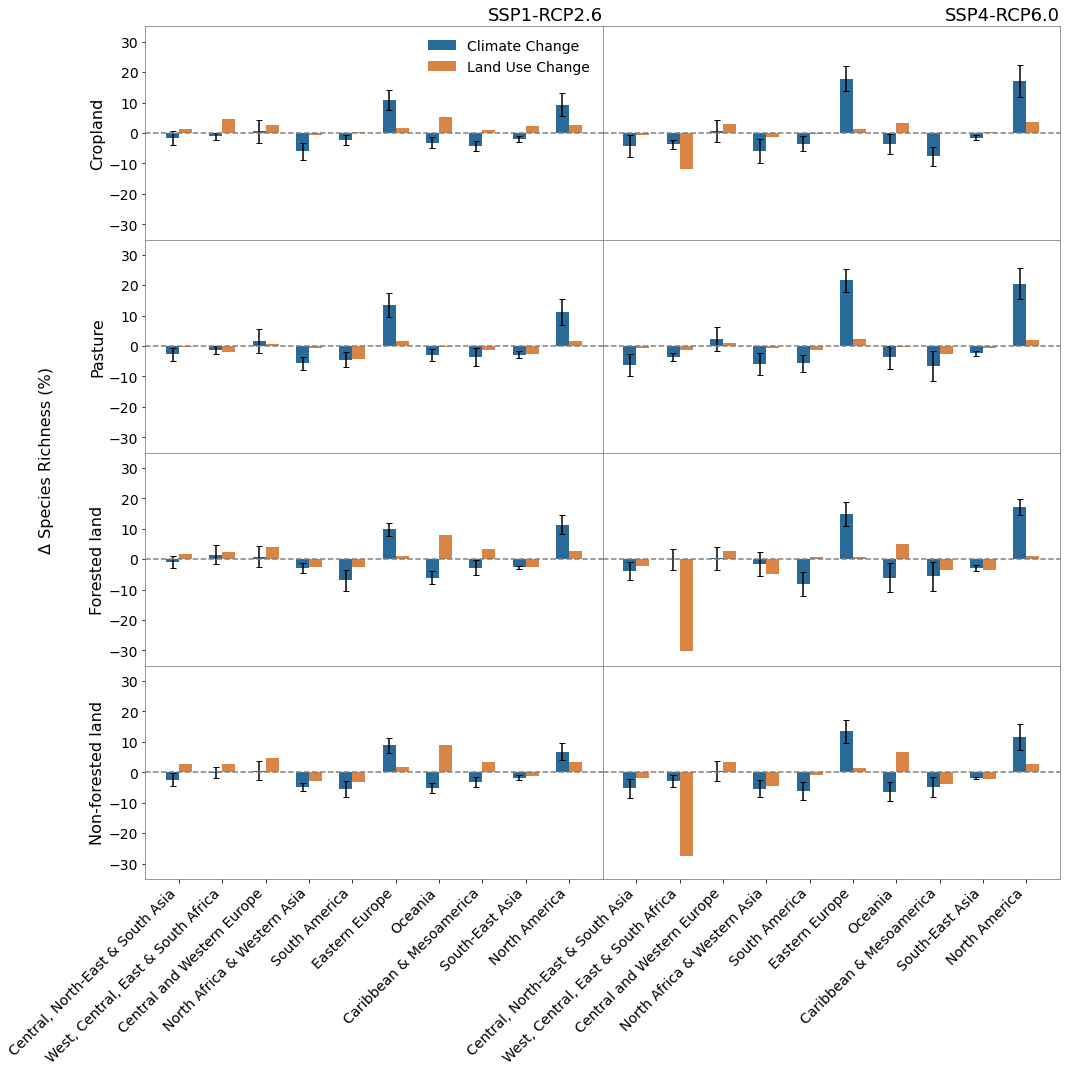

In [62]:

output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/habitats/"

# Assuming you have already read the shapefile and created the 'new_region' column
# If not, include the relevant code for reading and creating the 'new_region' column from your previous messages

regionlist = ['Central, North-East & South Asia','West, Central, East & South Africa', 'Central and Western Europe','North Africa & Western Asia', 'South America','Eastern Europe', 'Oceania', 'Caribbean & Mesoamerica', 'South-East Asia', 'North America'             ]
# Create an empty dictionary to store mean species richness for each region and each scenario
mean_species_richness_dict = {'sumbin_future': {}, 'sumbin_hist': {}, 'diff_sumbin': {}}
taxas = ["Bird"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenario = ["rcp26", "rcp60"] 
habitats=["cropland","pasture","forest","natural_land"]
scenarios = ["rcp26", "rcp60"]
historical_time = 1146
future_time = 65
time = '65'
time_ind=65


mean_newvalue_hist= {}
mean_newvalue_fut = {}
mean_sumbin_hist = {}
mean_sumbin_fut = {}
    
mean_over_sdms_gcms_hist = {}
mean_over_sdms_gcms_fut = {}
mean_over_sdms_gcms_sumbin_hist = {}
mean_over_sdms_gcms_sumbin_fut = {}

mean_over_all_sdms_gcms_hist = {}
mean_over_all_sdms_gcms_fut = {}
mean_over_all_sdms_gcms_sumbin_hist = {}
mean_over_all_sdms_gcms_sumbin_fut = {}


for scenario in scenarios:

    mean_over_sdms_gcms_hist[scenario] = {}
    mean_over_sdms_gcms_fut[scenario] = {}
    mean_over_sdms_gcms_sumbin_hist[scenario] = {}
    mean_over_sdms_gcms_sumbin_fut[scenario] = {}
    
    mean_over_all_sdms_gcms_hist[scenario] = {}
    mean_over_all_sdms_gcms_fut[scenario] = {}
    mean_over_all_sdms_gcms_sumbin_hist[scenario] = {}
    mean_over_all_sdms_gcms_sumbin_fut[scenario] = {}
    
    mean_newvalue_hist[scenario] = {}
    mean_newvalue_fut[scenario] = {}
    mean_sumbin_hist[scenario] = {}
    mean_sumbin_fut[scenario] = {}
    
    dataarrays_sdms_newvalue_hist = []
    dataarrays_sdms_newvalue_fut = []
    dataarrays_sdms_sumbin_hist = []
    dataarrays_sdms_sumbin_fut = []

    for habitat in habitats:

        # Initialize taxa-level lists
        dataarrays_sdms_newvalue_hist = []
        dataarrays_sdms_newvalue_fut = []
        dataarrays_sdms_sumbin_hist = []
        dataarrays_sdms_sumbin_fut = []
        
        mean_over_sdms_gcms_hist[scenario][habitat] = {}
        mean_over_sdms_gcms_fut[scenario][habitat] = {}
        mean_over_sdms_gcms_sumbin_hist[scenario][habitat] = {}
        mean_over_sdms_gcms_sumbin_fut[scenario][habitat] = {}

        mean_over_all_sdms_gcms_hist[scenario][habitat] = {}
        mean_over_all_sdms_gcms_fut[scenario][habitat] = {}
        mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat] = {}
        mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat] = {}

        mean_newvalue_hist[scenario][habitat] = {}
        mean_newvalue_fut[scenario][habitat] = {}
        mean_sumbin_hist[scenario][habitat] = {}
        mean_sumbin_fut[scenario][habitat] = {}

        for sdm in sdms:

            mean_newvalue_hist[scenario][habitat][sdm] = {}
            mean_newvalue_fut[scenario][habitat][sdm] = {}
            mean_sumbin_hist[scenario][habitat][sdm] = {}
            mean_sumbin_fut[scenario][habitat][sdm] = {}

            dataarrays_newvalue_hist = []
            dataarrays_newvalue_fut = []
            dataarrays_sumbin_hist = []
            dataarrays_sumbin_fut = []


            for gcm in gcms:
                mean_newvalue_hist[scenario][habitat][sdm][gcm] = {}
                mean_newvalue_fut[scenario][habitat][sdm][gcm] = {}
                mean_sumbin_hist[scenario][habitat][sdm][gcm] = {}
                mean_sumbin_fut[scenario][habitat][sdm][gcm] = {}

                sum_newvalue_hist = None
                sum_newvalue_future = None
                sum_sumbin_hist = None
                sum_sumbin_future = None

                # Load pickle files
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}']_dispersal4.pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}']_dispersal4.pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}']_dispersal4.pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{habitat}_['{scenario}']_['{time}']_dispersal4.pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_taxa = pd.read_pickle(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_taxa = pd.read_pickle(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_taxa = pd.read_pickle(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_taxa = pd.read_pickle(f)
                    
                weights_newvalue = np.cos(np.deg2rad(newvalue_hist_taxa.lat))
                weights_newvalue.name = "weights"

                    
                # Assign the summed values to your dictionary
                mean_newvalue_hist[scenario][habitat][sdm][gcm] = newvalue_hist_taxa
                mean_newvalue_fut[scenario][habitat][sdm][gcm] = newvalue_future_taxa
                mean_sumbin_hist[scenario][habitat][sdm][gcm] = sum_bin_hist_taxa
                mean_sumbin_fut[scenario][habitat][sdm][gcm] = sum_bin_future_taxa

                dataarrays_newvalue_hist.append(mean_newvalue_hist[scenario][habitat][sdm][gcm])
                dataarrays_newvalue_fut.append(mean_newvalue_fut[scenario][habitat][sdm][gcm])
                dataarrays_sumbin_hist.append(mean_sumbin_hist[scenario][habitat][sdm][gcm])
                dataarrays_sumbin_fut.append(mean_sumbin_fut[scenario][habitat][sdm][gcm])
                

            # Concatenate and calculate the mean over the new dimension
            mean_over_sdms_gcms_hist[scenario][habitat][sdm] = xr.concat(dataarrays_newvalue_hist, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')
            mean_over_sdms_gcms_fut[scenario][habitat][sdm] = xr.concat(dataarrays_newvalue_fut, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')
            mean_over_sdms_gcms_sumbin_hist[scenario][habitat][sdm] = xr.concat(dataarrays_sumbin_hist, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')
            mean_over_sdms_gcms_sumbin_fut[scenario][habitat][sdm] = xr.concat(dataarrays_sumbin_fut, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')

                   # Append the mean DataArrays across GCMs to the SDM lists
            dataarrays_sdms_newvalue_hist.append(mean_over_sdms_gcms_hist[scenario][habitat][sdm])
            dataarrays_sdms_newvalue_fut.append(mean_over_sdms_gcms_fut[scenario][habitat][sdm])
            dataarrays_sdms_sumbin_hist.append(mean_over_sdms_gcms_sumbin_hist[scenario][habitat][sdm])
            dataarrays_sdms_sumbin_fut.append(mean_over_sdms_gcms_sumbin_fut[scenario][habitat][sdm])

        # Concatenate and calculate the mean over SDMs
        mean_over_all_sdms_gcms_hist[scenario][habitat] = xr.concat(dataarrays_sdms_newvalue_hist, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
        mean_over_all_sdms_gcms_fut[scenario][habitat] = xr.concat(dataarrays_sdms_newvalue_fut, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
        mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat] = xr.concat(dataarrays_sdms_sumbin_hist, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
        mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat] = xr.concat(dataarrays_sdms_sumbin_fut, dim='sdm').weighted(weights_newvalue).mean(dim='sdm') 
        
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib as mpl

# Define some parameters for the bar plots
width = 0.5 # the width of the bars
min_threshold = 1e-6
# Create the x-axis positions for the bars
x = np.arange(len(regionlist)) / 2
scenario_indices={"rcp26": 'SSP1-RCP2.6', "rcp60": 'SSP4-RCP6.0'}
habitat_indices={"forest": 'Forested land', "natural_land": 'Non-forested land',"cropland": 'Cropland',"pasture": 'Pasture'}


# Create the x-axis positions for the bars
x = np.arange(len(regionlist))  # Assuming regionlist is the list of all regions




# Define figure and axes for the matrix of plots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))  # Adjust the size as needed

# Loop over each habitat and scenario to create each subplot
for i, habitat in enumerate(habitats):
    for j, scenario in enumerate(scenarios):
        ax = axes[i][j]  # This is the current axes object to plot on

        # Initialize lists for plotting
        rel_diff_newvalue_means = []
        rel_diff_sumbins = []
        std_dev_newvalue = []

        # Iterate over each region for the specific habitat and scenario
        for region in regionlist:
            oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
            oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
            sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
            oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')

            # Calculate th
            newvalue_future = mean_over_all_sdms_gcms_fut[scenario][habitat]
            newvalue_hist = mean_over_all_sdms_gcms_hist[scenario][habitat]
            sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario][habitat]
            sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario][habitat]



            # Calculate the relative difference safely
            non_zero_mask = sumbin_future != 0
            newvalue_hist_filtered = newvalue_hist.where(newvalue_hist > min_threshold, np.nan)
            difference = xr.where(newvalue_hist != 0, (newvalue_future - newvalue_hist) / newvalue_hist_filtered * 100, 0)
            climate_change = difference.where((difference >= -100) & (difference <= 100))

            climate_change = climate_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            sumbin_hist_filtered = sumbin_hist.where(sumbin_hist > min_threshold, np.nan)
            difference = (sumbin_future - sumbin_hist_filtered) / sumbin_hist_filtered * 100
            climate_land_change = difference.where((difference >= -100) & (difference <= 100))

            climate_land_change = climate_land_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)


            luc = climate_land_change - climate_change

            rel_diff_newvalue_mean = climate_change.mean()
            rel_diff_sumbin = luc.mean()

            # Append the values to the list
            rel_diff_newvalue_means.append(rel_diff_newvalue_mean)
            rel_diff_sumbins.append(rel_diff_sumbin)


            means_for_std = []

            for sdm in sdms:
                for gcm in gcms:

                    sep_future = mean_newvalue_fut[scenario][habitat][sdm][gcm]
                    sep_hist = mean_newvalue_hist[scenario][habitat][sdm][gcm]
                    sep_hist_filtered = sep_hist.where(sep_hist > min_threshold, np.nan)
                    difference = xr.where(sep_hist != 0, (sep_future - sep_hist) / sep_hist_filtered * 100, 0)
                    relative_change = difference.where((difference >= -100) & (difference <= 100))
                    relative_change = relative_change.where(non_zero_mask, np.nan).where(oceania_mask_renamed == 1)

                    # Calculate the mean for this SDM and GCM
                    mean_relative_change = np.nanmean(relative_change.values)
                    means_for_std.append(mean_relative_change)

            # Compute the standard deviation of these means
            std_dev_newvalue_region = np.nanstd(means_for_std)
            std_dev_newvalue.append(std_dev_newvalue_region)

        total_heights = np.array(rel_diff_newvalue_means) + np.array(rel_diff_sumbins)

        # Plotting the bars
        width = 0.3 # the width of the bars
        offset = width / 2  # Half the width of the bar
        x1 = x - offset  # Positions for the first set of bars
        x2 = x + offset  # Positions for the second set of bars

        # Plotting the bars with alpha for transparency
        ax.bar(x1, rel_diff_newvalue_means, width, label='Climate Change', color="#2a6a99")
        ax.bar(x2, rel_diff_sumbins, width, label='Land Use Change', color="#d88546")
        

        

        # Adding error bars
        ax.errorbar(x1,rel_diff_newvalue_means, yerr=std_dev_newvalue, fmt='none', capsize=3, color='black')

        ax.set_ylim([-35, 35])
        ax.axhline(y=0, color='gray', linestyle='--')
        # If this is the last row, set the x-tick labels
        if i == len(habitats) - 1:
            ax.set_xticks(x)
            ax.set_xticklabels(regionlist, rotation=45, ha='right', fontsize=14)
        else:
            ax.set_xticks([])  # No x-tick labels for other rows

        # If this is the first column, set the y-label

            
        if j == 1:
            ax.set_yticks([])


        # Set the title for the top row
        if i == 0:
            ax.set_title(f'{scenario_indices[scenario]}',loc='right')

        # Add the legend only for the first subplot or as per your preference
        if i == 0 and j == 0:
            ax.legend(frameon=False, fontsize=14)

# Add the habitat labels on the right side of the plot matrix
for i, habitat in enumerate(habitats):
    axes[i, -1].text(-1.12, 0.5, habitat_indices[habitat], transform=axes[i, -1].transAxes, rotation=90, va='center', fontsize=16)

fig.text(0.045, 0.57, 'Δ Species Richness (%)', va='center', rotation='vertical',fontsize=16)
set_plot_param()
# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)  # Adjust this value as needed
plt.savefig("/storage/homefs/ch21o450/scripts/climate_Hari_etal_inprep/functions/figures/main_figures/S_Birds")
# Show the plot
plt.show()